# MACHINE LEARNING MODEL RESULTS EVALUATION:

# Introduction:

The many trillions of cells within the human body are each sustained by the activities of thousands of genes in the genome. Genetic mutations prevent one or more of these genes from working properly; when such a mutation alters a gene that plays a critical role in the body, it can disrupt normal development and cause a medical condition. Many diseases do in fact arise due to the contribution of disruptions in multiple genes. To work towards cures for such complex diseases, the human genome has been studied through various experimental methods, each of which has provided a different and sometimes unique understanding of the disease’s underlying genetic cause.

We hypothesize that the genomic basis of complex diseases can be understood on a holistic level through the exploration and combination of genetic data from many distinct sources, experimental methods, and association types. This gene-disease exploration can lead to the discovery of new gene-disease associations, of old gene-disease associations being debunked, and of genes being correlated to multiple diseases, creating a network. Furthermore, genes for a disease can be labeled under one association type but not another, yet they all are mapped to the same disease. Thus, different experimental methods are providing different (and sometimes unique) views of the underlying genome, and we want to explore these comparisons. We want to see if we can develop supervised machine learning approaches to determine if, for a given disease, genes from an association type can be used to accurately predict genes from another type based on their patterns of interaction in a gene network. From there, it is hoped we can combine the machine learning models from the different association types into an ensemble model that discovers novel genes across the human genome associated with that disease. Such results can lead to a better understanding of the genomic basis of complex diseases and in the design of drugs that target and reverse the disease-related signals.

## Objectives:

*We try to answer:*
- Do different experimental methods provide the same view of the underlying biology, or do they present different aspects of it?
- Can models trained on one experimental method predict the genes associated to another?


## Question Raised:
- Can models trained on one association type predict the genes associated to another association type?

We wanted to see for any given disease, can models trained on one association type predict the genes associated to another category. I can determine this by using Anna’s code that she previously developed and applying it to our selected diseases.
We can then merge all these models together into an ensemble model for the disease to leverage the strength of all the association types and build a better model.

## Imports:

In [1]:
# Imports

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from networkx import DiGraph
import networkx as nx
import statistics
from itertools import permutations
from itertools import combinations #no longer being used
from IPython import display

## Reading in the Curated Dataset:

In [2]:
curated = pd.read_csv('DisGeNETFiles/curated_gene_disease_associations.tsv', sep = "\t")
curated

geneId geneSymbol    DSI    DPI diseaseId               diseaseName  \
0              1       A1BG  0.700  0.538  C0019209              Hepatomegaly   
1              1       A1BG  0.700  0.538  C0036341             Schizophrenia   
2              2        A2M  0.529  0.769  C0002395       Alzheimer's Disease   
3              2        A2M  0.529  0.769  C0007102  Malignant tumor of colon   
4              2        A2M  0.529  0.769  C0009375         Colonic Neoplasms   
...          ...        ...    ...    ...       ...                       ...   
84033  109580095    HBB-LCR  0.743  0.115  C0002875           Cooley's anemia   
84034  109580095    HBB-LCR  0.743  0.115  C0005283          beta Thalassemia   
84035  109580095    HBB-LCR  0.743  0.115  C0019025      Hemoglobin F Disease   
84036  109580095    HBB-LCR  0.743  0.115  C0085578         Thalassemia Minor   
84037  109580095    HBB-LCR  0.743  0.115  C0271979    Thalassemia Intermedia   

      diseaseType diseaseClass               diseaseSemanticType  score  \
0       phenotype      C23;C06                           Finding   0.30   
1         disease          F03  Mental or Behavioral Dysfunction   0.30   
2         disease      C10;F03               Disease or Syndrome   0.50   
3         disease      C06;C04                Neoplastic Process   0.31   
4           group      C06;C04                Neoplastic Process   0.30   
...           ...          ...                               ...    ...   
84033     disease      C16;C15               Disease or Syndrome   0.30   
84034     disease      C16;C15               Disease or Syndrome   0.30   
84035     disease      C16;C15               Disease or Syndrome   0.30   
84036     disease      C16;C15               Disease or Syndrome   0.30   
84037     disease      C16;C15               Disease or Syndrome   0.30   

          EI  YearInitial  YearFinal  NofPmids  NofSnps     source  
0      1.000       2017.0     2017.0         1        0  CTD_human  
1      1.000       2015.0     2015.0         1        0  CTD_human  
2      0.769       1998.0     2018.0         3        0  CTD_human  
3      1.000       2004.0     2019.0         1        0  CTD_human  
4      1.000       2004.0     2004.0         1        0  CTD_human  
...      ...          ...        ...       ...      ...        ...  
84033    NaN          NaN        NaN         0        0  CTD_human  
84034    NaN          NaN        NaN         0        0  CTD_human  
84035    NaN          NaN        NaN         0        0  CTD_human  
84036    NaN          NaN        NaN         0        0  CTD_human  
84037    NaN          NaN        NaN         0        0  CTD_human  

[84038 rows x 16 columns]

In [5]:
#Dropping data to only have the columns we need:
threeCol = curated.drop(columns = ['diseaseType', 'DSI', 'DPI', 'diseaseClass', 'diseaseSemanticType', 'score', 'EI', 'YearInitial', 'YearFinal', 'NofPmids', 'NofSnps'])
threeCol['source'] = threeCol['source'].apply(lambda x: set(x[:].split(";")))
threeColsep = pd.DataFrame([(c, tup.geneId, tup.geneSymbol, tup.diseaseId, tup.diseaseName) for tup in threeCol.itertuples() for c in tup.source])
threeColsep = threeColsep.rename(columns= {0: 'source', 1: 'geneId', 2: 'geneSymbol', 3: 'diseaseId', 4: 'diseaseName'})
threeColsep

source     geneId geneSymbol diseaseId               diseaseName
0      CTD_human          1       A1BG  C0019209              Hepatomegaly
1      CTD_human          1       A1BG  C0036341             Schizophrenia
2      CTD_human          2        A2M  C0002395       Alzheimer's Disease
3      CTD_human          2        A2M  C0007102  Malignant tumor of colon
4      CTD_human          2        A2M  C0009375         Colonic Neoplasms
...          ...        ...        ...       ...                       ...
96920  CTD_human  109580095    HBB-LCR  C0002875           Cooley's anemia
96921  CTD_human  109580095    HBB-LCR  C0005283          beta Thalassemia
96922  CTD_human  109580095    HBB-LCR  C0019025      Hemoglobin F Disease
96923  CTD_human  109580095    HBB-LCR  C0085578         Thalassemia Minor
96924  CTD_human  109580095    HBB-LCR  C0271979    Thalassemia Intermedia

[96925 rows x 5 columns]

In [3]:
#Using the diseasemappings file from DisGeNET to get DOID formatted diseases
diseasemappings = pd.read_csv('DisGeNETFiles/disease_mappings.tsv', sep = '\t')
diseasemappings = diseasemappings.drop(columns = ['vocabularyName'])
diseasemappings = diseasemappings.rename(columns = {'name': 'diseaseName'})
#Only keeping disease-gene pairs with DO as the vocabulary name
diseasemappings = diseasemappings[diseasemappings['vocabulary'].map(lambda d: d == 'DO')]
diseasemappings

diseaseId                  diseaseName vocabulary     code
0      C0018923              Hemangiosarcoma         DO  0001816
1      C0854893  Angiosarcoma non-metastatic         DO  0001816
2      C0033999                    Pterygium         DO  0002116
3      C0025517           Metabolic Diseases         DO  0014667
4      C0155862      Streptococcal pneumonia         DO  0040084
...         ...                          ...        ...      ...
13631  C0272192        Familial eosinophilia         DO      999
13632  C0014457                 Eosinophilia         DO      999
13633  C0311368      Idiopathic eosinophilia         DO      999
13634  C0020615                 Hypoglycemia         DO     9993
13635  C0877208    Peripartum cardiomyopathy         DO     9997

[13636 rows x 4 columns]

In [6]:
#Merging diseasemappings with curated dataset to help get the diseases into DOID format:
result2 = diseasemappings.merge(threeColsep)
#result2 = result1[result1['vocabulary'].map(lambda d: d == 'DO')]
result2['DOID'] = ('DOID:' + (result2['code']))
result2

diseaseId      diseaseName vocabulary     code            source  \
0      C0018923  Hemangiosarcoma         DO  0001816         CTD_human   
1      C0018923  Hemangiosarcoma         DO  0001816         CTD_human   
2      C0018923  Hemangiosarcoma         DO  0001816         CTD_human   
3      C0018923  Hemangiosarcoma         DO  0001816         CTD_human   
4      C0018923  Hemangiosarcoma         DO  0001816         CTD_human   
...         ...              ...        ...      ...               ...   
99446  C0020615     Hypoglycemia         DO     9993         CTD_human   
99447  C0020615     Hypoglycemia         DO     9993         CTD_human   
99448  C0020615     Hypoglycemia         DO     9993         CTD_human   
99449  C0020615     Hypoglycemia         DO     9993         CTD_human   
99450  C0020615     Hypoglycemia         DO     9993  GENOMICS_ENGLAND   

       geneId geneSymbol          DOID  
0         285     ANGPT2  DOID:0001816  
1         595      CCND1  DOID:0001816  
2        1440       CSF3  DOID:0001816  
3        1499     CTNNB1  DOID:0001816  
4        2321       FLT1  DOID:0001816  
...       ...        ...           ...  
99446    5465      PPARA     DOID:9993  
99447    6648       SOD2     DOID:9993  
99448    6927      HNF1A     DOID:9993  
99449    7124        TNF     DOID:9993  
99450   84947     SERAC1     DOID:9993  

[99451 rows x 8 columns]

In [7]:
#Grouping the genes into gene sets:
resultDOID = result2.groupby(by = ['DOID', 'diseaseName', 'source'])['geneId'].apply(lambda x: set(x))
resultDOID = resultDOID.reset_index()
resultDOID

DOID                    diseaseName            source  \
0      DOID:0001816                Hemangiosarcoma               CGI   
1      DOID:0001816                Hemangiosarcoma         CTD_human   
2      DOID:0002116                      Pterygium         CTD_human   
3      DOID:0002116                      Pterygium  GENOMICS_ENGLAND   
4      DOID:0014667             Metabolic Diseases         CTD_human   
...             ...                            ...               ...   
20005      DOID:998  Eosinophilia-Myalgia Syndrome         CTD_human   
20006      DOID:999                   Eosinophilia         CTD_human   
20007      DOID:999                   Eosinophilia  GENOMICS_ENGLAND   
20008     DOID:9993                   Hypoglycemia         CTD_human   
20009     DOID:9993                   Hypoglycemia  GENOMICS_ENGLAND   

                                                  geneId  
0                               {5335, 5787, 3845, 3791}  
1      {1440, 3265, 4609, 7010, 7424, 3845, 2701, 372...  
2                                                 {3440}  
3                                                {23299}  
4      {196, 1828, 5444, 3630, 2101, 51733, 5468, 140...  
...                                                  ...  
20005                                       {3123, 3117}  
20006        {2625, 81858, 4615, 5897, 3567, 7097, 7099}  
20007                                             {3572}  
20008  {3553, 775, 5465, 6648, 3630, 6927, 5265, 7124...  
20009                                            {84947}  

[20010 rows x 4 columns]

In [8]:
#Importing the Ontology Class and calling it disease_ontology
from ontology import Ontology
disease_ontology = Ontology()
disease_ontology.load("/mnt/research/compbio/krishnanlab/data/ontologies/doid.obo")

In [9]:
#Taking the curated dataset with gene sets and dropping the disease name column
resultDOIDshort = resultDOID.drop(columns = 'diseaseName')
#Creating a dictionary for each source.
dict_of_sources = dict(iter(resultDOIDshort.groupby('source')))

In [10]:
#Creaing a separate dictionary for each source
CLINGEN_dict = dict(zip(dict_of_sources['CLINGEN'].DOID, dict_of_sources['CLINGEN'].geneId))
CTD_human_dict = dict(zip(dict_of_sources['CTD_human'].DOID, dict_of_sources['CTD_human'].geneId))
CGI_dict = dict(zip(dict_of_sources['CGI'].DOID, dict_of_sources['CGI'].geneId))
GENOMICS_ENGLAND_dict = dict(zip(dict_of_sources['GENOMICS_ENGLAND'].DOID, dict_of_sources['GENOMICS_ENGLAND'].geneId))
UNIPROT_dict = dict(zip(dict_of_sources['UNIPROT'].DOID, dict_of_sources['UNIPROT'].geneId))
ORPHANET_dict = dict(zip(dict_of_sources['ORPHANET'].DOID, dict_of_sources['ORPHANET'].geneId))
PSYGENET_dict = dict(zip(dict_of_sources['PSYGENET'].DOID, dict_of_sources['PSYGENET'].geneId))

In [11]:
#Creating a propagated dictionary for each source
CLINGEN_prop = disease_ontology.propagate(CLINGEN_dict)
CTD_human_prop = disease_ontology.propagate(CTD_human_dict)
CGI_prop = disease_ontology.propagate(CGI_dict)
GENOMICS_ENGLAND_prop = disease_ontology.propagate(GENOMICS_ENGLAND_dict)
UNIPROT_prop = disease_ontology.propagate(UNIPROT_dict)
ORPHANET_prop = disease_ontology.propagate(ORPHANET_dict)
PSYGENET_prop = disease_ontology.propagate(PSYGENET_dict)

In [12]:
#Turning each dictionary into a dataframe
CLINGEN = pd.DataFrame([k for k in CLINGEN_prop.items()], columns=['DOID', 'geneSet'])
CTD_human = pd.DataFrame([k for k in CTD_human_prop.items()], columns=['DOID', 'geneSet'])
CGI = pd.DataFrame([k for k in CGI_prop.items()], columns=['DOID', 'geneSet'])
GENOMICS_ENGLAND = pd.DataFrame([k for k in GENOMICS_ENGLAND_prop.items()], columns=['DOID', 'geneSet'])
ORPHANET = pd.DataFrame([k for k in ORPHANET_prop.items()], columns=['DOID', 'geneSet'])
UNIPROT = pd.DataFrame([k for k in UNIPROT_prop.items()], columns=['DOID', 'geneSet'])
PSYGENET = pd.DataFrame([k for k in PSYGENET_prop.items()], columns=['DOID', 'geneSet'])

In [13]:
#Creating a column in each source dataset for the name of the dataset (so that this info will be available once the datasets are apended back together)
CLINGEN['source'] = 'CLINGEN'
CTD_human['source'] = 'CTD_human'
CGI['source'] = 'CGI'
GENOMICS_ENGLAND['source'] = 'GENOMICS_ENGLAND'
ORPHANET['source'] = 'ORPHANET'
UNIPROT['source'] = 'UNIPROT'
PSYGENET['source'] = 'PSYGENET'

In [14]:
#Appending the datasets together
propagated = CLINGEN.append(CTD_human).append(CGI).append(GENOMICS_ENGLAND).append(ORPHANET).append(UNIPROT).append(PSYGENET)
propagated

DOID                                            geneSet    source
0   DOID:0050332                                       {2299, 3766}   CLINGEN
1      DOID:2742                     {4641, 9381, 3766, 1687, 2299}   CLINGEN
2   DOID:0050155  {65217, 25861, 64072, 4043, 22926, 4942, 23568...   CLINGEN
3       DOID:863  {25861, 2566, 22926, 23568, 785, 9364, 1687, 2...   CLINGEN
4      DOID:3426                                       {2299, 3766}   CLINGEN
..           ...                                                ...       ...
44      DOID:809  {4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...  PSYGENET
45     DOID:8645  {6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...  PSYGENET
46     DOID:9478      {8864, 6532, 3350, 4988, 50809, 4524, 148014}  PSYGENET
47     DOID:9505  {6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...  PSYGENET
48     DOID:9975  {6531, 6532, 2950, 255239, 4988, 148, 1813, 18...  PSYGENET

[15862 rows x 3 columns]

In [15]:
#Adding the disease name back into the dataset
templist = []
for index, row, in propagated.iterrows():
    if (row['DOID'] in disease_ontology.nodes):
        templist.append(disease_ontology.nodes[row['DOID']]["name"])
    else:
        templist.append("error")
propagated['diseaseName'] = templist
propagated

DOID                                            geneSet    source  \
0   DOID:0050332                                       {2299, 3766}   CLINGEN   
1      DOID:2742                     {4641, 9381, 3766, 1687, 2299}   CLINGEN   
2   DOID:0050155  {65217, 25861, 64072, 4043, 22926, 4942, 23568...   CLINGEN   
3       DOID:863  {25861, 2566, 22926, 23568, 785, 9364, 1687, 2...   CLINGEN   
4      DOID:3426                                       {2299, 3766}   CLINGEN   
..           ...                                                ...       ...   
44      DOID:809  {4929, 1666, 6531, 4900, 9607, 255239, 5354, 1...  PSYGENET   
45     DOID:8645  {6531, 3557, 3976, 7054, 3569, 1813, 1814, 347...  PSYGENET   
46     DOID:9478      {8864, 6532, 3350, 4988, 50809, 4524, 148014}  PSYGENET   
47     DOID:9505  {6532, 51083, 3084, 4684, 26575, 1813, 1815, 1...  PSYGENET   
48     DOID:9975  {6531, 6532, 2950, 255239, 4988, 148, 1813, 18...  PSYGENET   

                     diseaseName  
0   enlarged vestibular aqueduct  
1        auditory system disease  
2         sensory system disease  
3         nervous system disease  
4             vestibular disease  
..                           ...  
44                 cocaine abuse  
45             subacute delirium  
46         postpartum depression  
47                cannabis abuse  
48            cocaine dependence  

[15862 rows x 4 columns]

In [16]:
#Reading in Dataset with Selected DOIDS
selected = pd.read_csv('OutputFiles/selectedDOIDS.csv')
selected = selected.rename(columns = {'dis_doid': 'DOID'})

#Merging dataset with propagated; now this result dataset has the data for our selected DOIDS as well as the gene set and source, necessary to create Jaccard Index Heatmap
result = selected.merge(propagated, how = 'inner')
result

DOID                                           dis_name  \
0        DOID:162                                             cancer   
1        DOID:162                                             cancer   
2        DOID:162                                             cancer   
3        DOID:162                                             cancer   
4        DOID:162                                             cancer   
..            ...                                                ...   
398  DOID:0110274  autosomal recessive limb-girdle muscular dystr...   
399  DOID:0050534              congenital stationary night blindness   
400  DOID:0050534              congenital stationary night blindness   
401  DOID:0050534              congenital stationary night blindness   
402  DOID:0050534              congenital stationary night blindness   

     numgenes_CLINGEN  numgenes_CGI  numgenes_CTD_human  \
0                  32           307                2963   
1                  32           307                2963   
2                  32           307                2963   
3                  32           307                2963   
4                  32           307                2963   
..                ...           ...                 ...   
398                 0             0                  12   
399                 0             0                  14   
400                 0             0                  14   
401                 0             0                  14   
402                 0             0                  14   

     numgenes_GENOMICS_ENGLAND  numgenes_ORPHANET  numgenes_PSYGENET  \
0                          168                247                  0   
1                          168                247                  0   
2                          168                247                  0   
3                          168                247                  0   
4                          168                247                  0   
..                         ...                ...                ...   
398                         23                  9                  0   
399                         11                  2                  0   
400                         11                  2                  0   
401                         11                  2                  0   
402                         11                  2                  0   

     numgenes_UNIPROT  numgenes_dir  numgenes_prop  numsource_ge10  \
0                 740           128           3574               6   
1                 740           128           3574               6   
2                 740           128           3574               6   
3                 740           128           3574               6   
4                 740           128           3574               6   
..                ...           ...            ...             ...   
398                20             8             30               3   
399                10            17             14               3   
400                10            17             14               3   
401                10            17             14               3   
402                10            17             14               3   

                                               geneSet            source  \
0    {11200, 5889, 5892, 580, 4292, 6598, 7046, 436...           CLINGEN   
1    {2, 9, 10, 100499467, 8202, 12, 8204, 10004891...         CTD_human   
2    {2048, 1026, 1027, 7172, 1029, 1030, 1031, 171...               CGI   
3    {1027, 1028, 1029, 54790, 4615, 171023, 5649, ...  GENOMICS_ENGLAND   
4    {2048, 4609, 7170, 7171, 1029, 54790, 4615, 71...          ORPHANET   
..                                                 ...               ...   
398  {729920, 29954, 1605, 55624, 60684, 11149, 203...           UNIPROT   
399  {778, 4308, 6295, 60506, 2779, 2784, 9187, 291...         CTD_human   
400  {9187, 2916, 60506, 5158, 345193, 778, 44043

In [21]:
# Creating Sets of Sources Based on Disease
a2 = result.groupby(by = ['DOID'])['source'].apply(lambda x: set(x))
a2 = a2.to_frame().reset_index()

# Creating the Different Possible Combinations of Sources for Each Disease:
from itertools import permutations
a2['permutations'] = a2['source'].apply(lambda r: list(permutations(r, 2)))

# Removing the Diseases that Only Hold One Source:
a3 = a2[a2['permutations'].map(lambda d: len(d)) > 0]

# Making a Separate Row for Each Combination:
resultGE = pd.DataFrame([(c, tup.DOID) for tup in a3.itertuples() for c in tup.permutations])
resultGE = resultGE.rename(columns={0: 'Combos', 1: 'DOID'})

# Separating the Created Combinations into 2 Columns:
resultGE[['SourceTrain','SourceEval']] = pd.DataFrame(resultGE.Combos.tolist(), index= resultGE.index)
resultGE

Combos          DOID SourceTrain  \
0                   (CGI, ORPHANET)  DOID:0014667         CGI   
1           (CGI, GENOMICS_ENGLAND)  DOID:0014667         CGI   
2                    (CGI, UNIPROT)  DOID:0014667         CGI   
3                    (CGI, CLINGEN)  DOID:0014667         CGI   
4                   (CGI, PSYGENET)  DOID:0014667         CGI   
...                             ...           ...         ...   
1753  (CTD_human, GENOMICS_ENGLAND)     DOID:9884   CTD_human   
1754           (CTD_human, UNIPROT)     DOID:9884   CTD_human   
1755            (UNIPROT, ORPHANET)     DOID:9884     UNIPROT   
1756    (UNIPROT, GENOMICS_ENGLAND)     DOID:9884     UNIPROT   
1757           (UNIPROT, CTD_human)     DOID:9884     UNIPROT   

            SourceEval  
0             ORPHANET  
1     GENOMICS_ENGLAND  
2              UNIPROT  
3              CLINGEN  
4             PSYGENET  
...                ...  
1753  GENOMICS_ENGLAND  
1754           UNIPROT  
1755          ORPHANET  
1756  GENOMICS_ENGLAND  
1757         CTD_human  

[1758 rows x 4 columns]

In [22]:
#Finding the gene sets associated to each gene-disease pair source
arowList = []
arow2List = []
for index, row in resultGE.iterrows():
    midrow = result.loc[(result['DOID'] == row['DOID']) & (result['source'] == row['SourceTrain'])]
    arowList.append(midrow.iloc[0]['geneSet'])
    
    midrow2 = result.loc[(result['DOID'] == row['DOID']) & (result['source'] == row['SourceEval'])]
    arow2List.append(midrow2.iloc[0]['geneSet'])

In [23]:
#Adding the gene sets back into the dataset
resultGE['geneId1'] = arowList
resultGE['geneId2'] = arow2List
resultGE = resultGE.drop(columns = ['Combos'])
resultGE['jaccardIndex'] = np.nan

In [24]:
# Jaccard Similarity Coefficient/Jaccard Index Function:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [25]:
#Helper function for Jaccard Index
def f(x):
    return jaccard(x['geneId1'], x['geneId2']) 

In [26]:
#Obtaining Jaccard Similarity Coefficient Between Gene Sets for each Row
resultGE['jaccardIndex'] = resultGE.apply(f, axis = 1)
resultGE

DOID SourceTrain        SourceEval  \
0     DOID:0014667         CGI          ORPHANET   
1     DOID:0014667         CGI  GENOMICS_ENGLAND   
2     DOID:0014667         CGI           UNIPROT   
3     DOID:0014667         CGI           CLINGEN   
4     DOID:0014667         CGI          PSYGENET   
...            ...         ...               ...   
1753     DOID:9884   CTD_human  GENOMICS_ENGLAND   
1754     DOID:9884   CTD_human           UNIPROT   
1755     DOID:9884     UNIPROT          ORPHANET   
1756     DOID:9884     UNIPROT  GENOMICS_ENGLAND   
1757     DOID:9884     UNIPROT         CTD_human   

                                                geneId1  \
0                                                {4615}   
1                                                {4615}   
2                                                {4615}   
3                                                {4615}   
4                                                {4615}   
...                                                 ...   
1753  {7169, 29954, 7170, 1281, 1026, 1291, 1292, 12...   
1754  {7169, 29954, 7170, 1281, 1026, 1291, 1292, 12...   
1755  {29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...   
1756  {29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...   
1757  {29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...   

                                                geneId2  jaccardIndex  
0     {644096, 513, 514, 140803, 10243, 3073, 3074, ...      0.003953  
1     {644096, 3073, 3074, 10243, 7172, 3077, 378884...      0.000000  
2     {644096, 1537, 514, 140803, 90624, 3077, 10243...      0.000000  
3     {51204, 3081, 9997, 374291, 55572, 275, 55065,...      0.000000  
4                                            {217, 125}      0.000000  
...                                                 ...           ...  
1753  {7169, 7170, 29954, 9987, 1291, 1292, 1293, 47...      0.369565  
1754  {29954, 9987, 7170, 1291, 1292, 1293, 60684, 1...      0.317647  
1755  {7169, 1282, 29954, 9987, 1674, 1291, 1292, 12...      0.444444  
1756  {7169, 7170, 29954, 9987, 1291, 1292, 1293, 47...      0.627119  
1757  {7169, 29954, 7170, 1281, 1026, 1291, 1292, 12...      0.317647  

[1758 rows x 6 columns]

## Appending Results of Machine Learning Model into One Dataset:

Brief Overview of the Machine Learning Approach: All of the selected labels would be split into 3 folds and each of the 77 diseases would be trained on its sources it has labels for. We would then unsplit the folds and evaluate on another source that disease has information/label for. After the evaluation process, files listing numerous model performance metrics are created and amended into a single dataset.

In [27]:
#Function to run when you get the whole dataset:
import glob

path = "./modelResults"
all_files = glob.glob(path + "/*.tsv")
df = pd.concat((pd.read_csv(f, sep = '\t').assign(filename = f) for f in all_files))

df['filename'] = df['filename'].apply(lambda x: (x[7:]))
df[['DOID','SourceTrain']] = df.filename.str.split("_source=",expand=True)
df[['SourceTrain', 'Dummy', 'SourceEval']] = df.SourceTrain.str.split('=', expand = True)
df['SourceTrain'] = df['SourceTrain'].apply(lambda x: (x[:-6]))
df['SourceEval'] = df['SourceEval'].apply(lambda x: (x[:-4]))
df = df.drop(columns = ['filename', 'Dummy'])
df

auROC  log2(auPRC/prior)  log2(P@r10/prior)  log2(P@r20/prior)  \
0   0.873233           2.614241           3.147584           2.799661   
0   0.708895           0.977403           1.990186           1.797541   
0   0.751768           1.353335           1.634851           1.634851   
0   0.645484           0.817277           1.232059           1.232059   
0   0.813164           2.210550           3.086537           2.786976   
..       ...                ...                ...                ...   
0   0.773690           0.517985           0.348399           0.541044   
0   0.672131           0.669673               -inf               -inf   
0   0.796087           1.007461           1.588456           1.353990   
0   0.834118           0.460756           0.612854           0.612854   
0   0.863722           2.988346           3.754888           2.754888   

    log2(P@r50/prior)     R@r10     R@r20     R@r50          DOID  \
0            2.662157  0.148936  0.234043  0.531915     DOID:8692   
0            1.191820  0.067797  0.118644  0.194915      DOID:936   
0            1.705241  0.055556  0.111111  0.291667      DOID:150   
0            1.232059  0.039216  0.078431  0.196078      DOID:263   
0            2.349571  0.145455  0.236364  0.436364     DOID:2256   
..                ...       ...       ...       ...           ...   
0            0.645380  0.011532  0.026359  0.070840       DOID:74   
0                -inf  0.000000  0.000000  0.000000     DOID:1793   
0            1.266528  0.036364  0.061818  0.145455  DOID:0080199   
0            0.612854  0.011050  0.022099  0.055249     DOID:2914   
0            2.017922  0.250000  0.250000  0.375000      DOID:178   

         SourceTrain SourceEval  
0          CTD-human        CGI  
0                CGI    UNIPROT  
0          CTD-human    UNIPROT  
0            UNIPROT   ORPHANET  
0   GENOMICS-ENGLAND   ORPHANET  
..               ...        ...  
0   GENOMICS-ENGLAND  CTD-human  
0   GENOMICS-ENGLAND    UNIPROT  
0          CTD-human  CTD-human  
0          CTD-human  CTD-human  
0            UNIPROT    UNIPROT  

[2093 rows x 11 columns]

In [28]:
#We had changed the names of Genomics England and CTD human to have dashes instead of underscores so that they could succesfully move through the model.
resultGE.loc[resultGE['SourceTrain'] == 'GENOMICS_ENGLAND', 'SourceTrain'] = 'GENOMICS-ENGLAND'
resultGE.loc[resultGE['SourceEval'] == 'GENOMICS_ENGLAND', 'SourceEval'] = 'GENOMICS-ENGLAND'
resultGE.loc[resultGE['SourceEval'] == 'CTD_human', 'SourceEval'] = 'CTD-human'
resultGE.loc[resultGE['SourceTrain'] == 'CTD_human', 'SourceTrain'] = 'CTD-human'

In [29]:
#Merging results of machine learning model to resultGE to get a dataset with all the info we would need to create the three heatmaps for each disease
finale = df.merge(resultGE, how = 'outer', on = ['DOID', 'SourceTrain', 'SourceEval'])
finale

auROC  log2(auPRC/prior)  log2(P@r10/prior)  log2(P@r20/prior)  \
0     0.873233           2.614241           3.147584           2.799661   
1     0.708895           0.977403           1.990186           1.797541   
2     0.751768           1.353335           1.634851           1.634851   
3     0.645484           0.817277           1.232059           1.232059   
4     0.813164           2.210550           3.086537           2.786976   
...        ...                ...                ...                ...   
2144       NaN                NaN                NaN                NaN   
2145       NaN                NaN                NaN                NaN   
2146       NaN                NaN                NaN                NaN   
2147       NaN                NaN                NaN                NaN   
2148       NaN                NaN                NaN                NaN   

      log2(P@r50/prior)     R@r10     R@r20     R@r50       DOID  \
0              2.662157  0.148936  0.234043  0.531915  DOID:8692   
1              1.191820  0.067797  0.118644  0.194915   DOID:936   
2              1.705241  0.055556  0.111111  0.291667   DOID:150   
3              1.232059  0.039216  0.078431  0.196078   DOID:263   
4              2.349571  0.145455  0.236364  0.436364  DOID:2256   
...                 ...       ...       ...       ...        ...   
2144                NaN       NaN       NaN       NaN  DOID:8692   
2145                NaN       NaN       NaN       NaN  DOID:8692   
2146                NaN       NaN       NaN       NaN  DOID:8692   
2147                NaN       NaN       NaN       NaN  DOID:8692   
2148                NaN       NaN       NaN       NaN  DOID:8692   

           SourceTrain SourceEval  \
0            CTD-human        CGI   
1                  CGI    UNIPROT   
2            CTD-human    UNIPROT   
3              UNIPROT   ORPHANET   
4     GENOMICS-ENGLAND   ORPHANET   
...                ...        ...   
2144               CGI    CLINGEN   
2145          ORPHANET    CLINGEN   
2146  GENOMICS-ENGLAND    CLINGEN   
2147           UNIPROT    CLINGEN   
2148         CTD-human    CLINGEN   

                                                geneId1  \
0     {4609, 2052, 54790, 3082, 359948, 171023, 3605...   
1     {3845, 84231, 5395, 673, 546, 4771, 1956, 5156...   
2     {55297, 1, 10243, 4099, 2053, 151556, 79875, 2...   
3     {7428, 4233, 29072, 657, 53904, 2324, 2081, 67...   
4     {1280, 23169, 64131, 6662, 6023, 4998, 5000, 8...   
...                                                 ...   
2144  {2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...   
2145  {5573, 4869, 81608, 2120, 359948, 2322, 7704, ...   
2146  {2176, 641, 2177, 2178, 5888, 5889, 23305, 218...   
2147  {2146, 339970, 3717, 54790, 7403, 29072, 2322,...   
2148  {4609, 2052, 54790, 3082, 359948, 171023, 3605...   

                                                geneId2  jaccardIndex  
0     {2176, 2177, 2178, 3716, 4869, 3717, 3845, 730...      0.089202  
1     {3329, 1282, 2051, 1018, 378884, 57094, 55561,...      0.020408  
2     {7552, 10369, 8450, 23431, 6664, 55690, 1804, ...      0.062048  
3     {2304, 283008, 3845, 7175, 51079, 51592, 4233,...      0.054795  
4     {1280, 23169, 64131, 6662, 8200, 649, 60681, 2...      0.476744  
...                                                 ...           ...  
2144                                             {1050}      0.021277  
2145                                             {1050}      0.000000  
2146                                             {1050}      0.028571  
2147                                             {1050}      0.076923  
2148                                             {1050}      0.005405  

[2149 rows x 14 columns]

In [30]:
#Merging the above dataset with selected to get the other columns with information on number of genes per column as well as the number of unique genes
finale = finale.merge(selected)
finale

auROC  log2(auPRC/prior)  log2(P@r10/prior)  log2(P@r20/prior)  \
0     0.873233           2.614241           3.147584           2.799661   
1     0.718978           1.806436           2.505891           2.090853   
2     0.752640           2.188159           3.147584           2.925191   
3     0.846142           2.938505           3.321103           3.195573   
4     0.845673           3.228809           3.736141           3.643032   
...        ...                ...                ...                ...   
2144  0.596632           0.821606           1.830357           0.830357   
2145  0.546655           0.155536               -inf               -inf   
2146  0.797173           1.476324           1.736966           2.017074   
2147  0.833635           3.221300           3.493135           3.815063   
2148  0.789444           3.736073           4.152285           3.637712   

      log2(P@r50/prior)     R@r10     R@r20     R@r50       DOID  \
0              2.662157  0.148936  0.234043  0.531915  DOID:8692   
1              1.991318  0.100000  0.150000  0.350000  DOID:8692   
2              2.105764  0.148936  0.255319  0.361702  DOID:8692   
3              2.662140  0.171429  0.314286  0.542857  DOID:8692   
4              2.806530  0.228571  0.428571  0.600000  DOID:8692   
...                 ...       ...       ...       ...        ...   
2144           1.093391  0.062500  0.062500  0.187500   DOID:365   
2145               -inf  0.000000  0.000000  0.000000   DOID:365   
2146           2.000000  0.047619  0.115646  0.285714   DOID:365   
2147           2.756169  0.200000  0.500000  0.600000   DOID:365   
2148           2.830357  0.312500  0.437500  0.625000   DOID:365   

           SourceTrain  ... numgenes_CLINGEN numgenes_CGI numgenes_CTD_human  \
0            CTD-human  ...                1           47                185   
1              UNIPROT  ...                1           47                185   
2     GENOMICS-ENGLAND  ...                1           47                185   
3                  CGI  ...                1           47                185   
4     GENOMICS-ENGLAND  ...                1           47                185   
...                ...  ...              ...          ...                ...   
2144           UNIPROT  ...                0           16                148   
2145           UNIPROT  ...                0           16                148   
2146         CTD-human  ...                0           16                148   
2147         CTD-human  ...                0           16                148   
2148               CGI  ...                0           16                148   

      numgenes_GENOMICS_ENGLAND numgenes_ORPHANET  numgenes_PSYGENET  \
0                            35                20                  0   
1                            35                20                  0   
2                            35                20                  0   
3                            35                20                  0   
4                            35                20                  0   
...                         ...               ...                ...   
2144                          0                 0                  0   
2145                          0                 0                  0   
2146                          0                 0                  0   
2147                          0                 0                  0   
2148                          0                 0                  0   

      numgenes_UNIPROT  numgenes_dir  numgenes_prop  numsource_ge10  
0                   13            26            240               5  
1                   13            26            240               5  
2                   13            26            240               5  
3                   13            26            240               5  
4                   13            26            240               5  
...                ...           ...         

In [31]:
#Creating Labels that can be used for the axis of the heatmap (Source, Number of Genes for that Source)
Trainlist = []

for index, row in finale.iterrows():
    if (row['SourceTrain'] == 'CLINGEN'):
        temp = row['SourceTrain'] + ', ' + str(row['numgenes_CLINGEN'])
        Trainlist.append(temp)
    elif (row['SourceTrain'] == 'CGI'):
        temp = row['SourceTrain'] + ', ' + str(row['numgenes_CGI'])
        Trainlist.append(temp)
    elif (row['SourceTrain'] == 'CTD-human'):
        temp = row['SourceTrain'] + ', ' + str(row['numgenes_CTD_human'])
        Trainlist.append(temp)                                           
    elif (row['SourceTrain'] == 'GENOMICS-ENGLAND'):
        temp = row['SourceTrain'] + ', ' + str(row['numgenes_GENOMICS_ENGLAND'])
        Trainlist.append(temp)
    elif (row['SourceTrain'] == 'ORPHANET'):
        temp = row['SourceTrain'] + ', ' + str(row['numgenes_ORPHANET'])
        Trainlist.append(temp)
    elif (row['SourceTrain'] == 'PSYGENET'):
        temp = row['SourceTrain'] + ', ' + str(row['numgenes_PSYGENET'])
        Trainlist.append(temp)
    elif (row['SourceTrain'] == 'UNIPROT'):
        temp = row['SourceTrain'] + ', ' + str(row['numgenes_UNIPROT'])
        Trainlist.append(temp)
finale['SourceTrainG'] = Trainlist
finale

auROC  log2(auPRC/prior)  log2(P@r10/prior)  log2(P@r20/prior)  \
0     0.873233           2.614241           3.147584           2.799661   
1     0.718978           1.806436           2.505891           2.090853   
2     0.752640           2.188159           3.147584           2.925191   
3     0.846142           2.938505           3.321103           3.195573   
4     0.845673           3.228809           3.736141           3.643032   
...        ...                ...                ...                ...   
2144  0.596632           0.821606           1.830357           0.830357   
2145  0.546655           0.155536               -inf               -inf   
2146  0.797173           1.476324           1.736966           2.017074   
2147  0.833635           3.221300           3.493135           3.815063   
2148  0.789444           3.736073           4.152285           3.637712   

      log2(P@r50/prior)     R@r10     R@r20     R@r50       DOID  \
0              2.662157  0.148936  0.234043  0.531915  DOID:8692   
1              1.991318  0.100000  0.150000  0.350000  DOID:8692   
2              2.105764  0.148936  0.255319  0.361702  DOID:8692   
3              2.662140  0.171429  0.314286  0.542857  DOID:8692   
4              2.806530  0.228571  0.428571  0.600000  DOID:8692   
...                 ...       ...       ...       ...        ...   
2144           1.093391  0.062500  0.062500  0.187500   DOID:365   
2145               -inf  0.000000  0.000000  0.000000   DOID:365   
2146           2.000000  0.047619  0.115646  0.285714   DOID:365   
2147           2.756169  0.200000  0.500000  0.600000   DOID:365   
2148           2.830357  0.312500  0.437500  0.625000   DOID:365   

           SourceTrain  ... numgenes_CGI numgenes_CTD_human  \
0            CTD-human  ...           47                185   
1              UNIPROT  ...           47                185   
2     GENOMICS-ENGLAND  ...           47                185   
3                  CGI  ...           47                185   
4     GENOMICS-ENGLAND  ...           47                185   
...                ...  ...          ...                ...   
2144           UNIPROT  ...           16                148   
2145           UNIPROT  ...           16                148   
2146         CTD-human  ...           16                148   
2147         CTD-human  ...           16                148   
2148               CGI  ...           16                148   

     numgenes_GENOMICS_ENGLAND  numgenes_ORPHANET numgenes_PSYGENET  \
0                           35                 20                 0   
1                           35                 20                 0   
2                           35                 20                 0   
3                           35                 20                 0   
4                           35                 20                 0   
...                        ...                ...               ...   
2144                         0                  0                 0   
2145                         0                  0                 0   
2146                         0                  0                 0   
2147                         0                  0                 0   
2148                         0                  0                 0   

      numgenes_UNIPROT  numgenes_dir  numgenes_prop  numsource_ge10  \
0                   13            26            240               5   
1                   13            26            240               5   
2                   13            26            240               5   
3                   13            26            240               5   
4                   13            26            240               5   
...                ...           ...            ...             ...   
2144                10             5            163               3   
2145                10             5            163               3   
2146                10             5      

In [32]:
#Creating a dictionary, where keys are DOIDS, and labels are all the other columns in the dataset 'finale'
dict_of_DOIDS = dict(iter(finale.groupby('DOID')))

In [34]:
#Created dictionary just to get the gene count for the title
dictGeneCounts = selected.set_index('DOID').to_dict()['numgenes_prop']

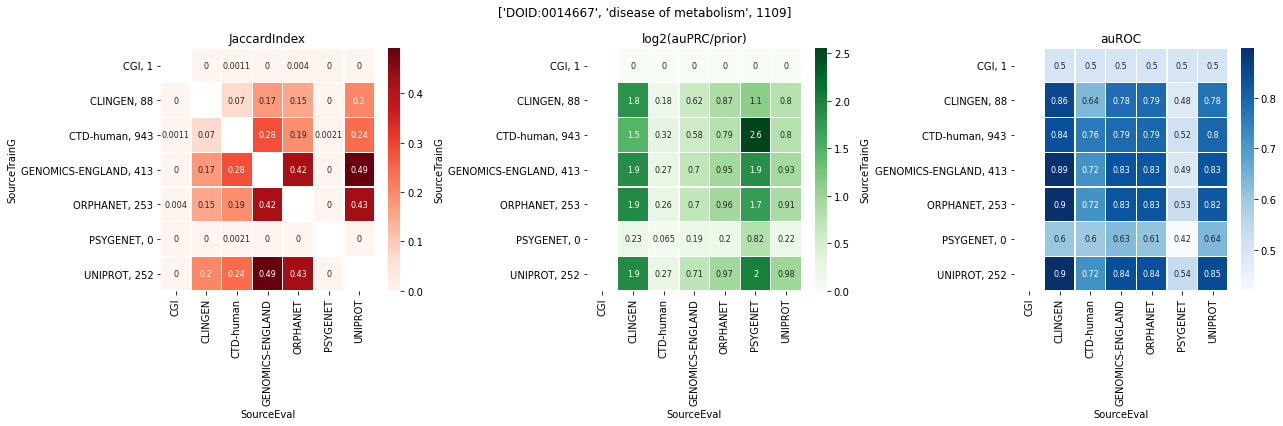

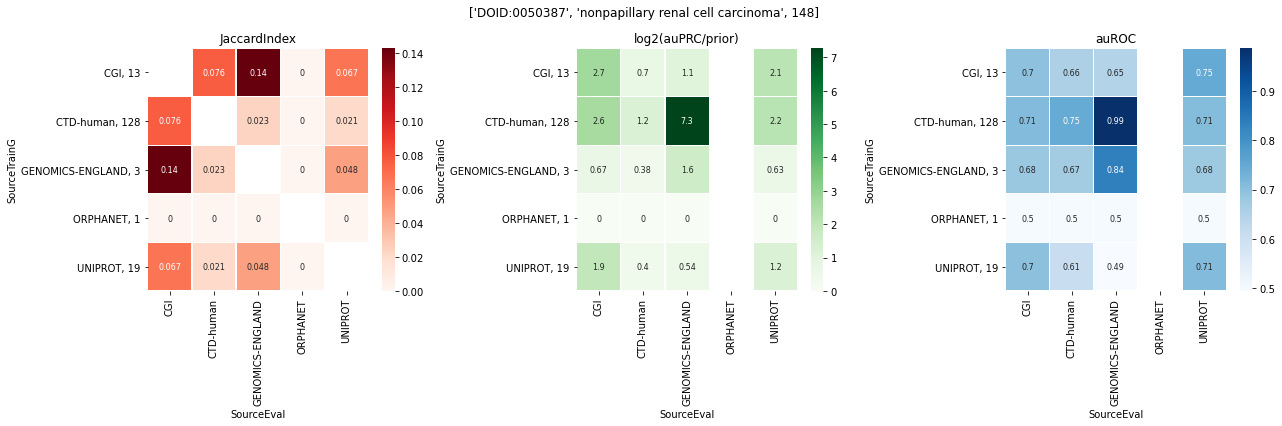

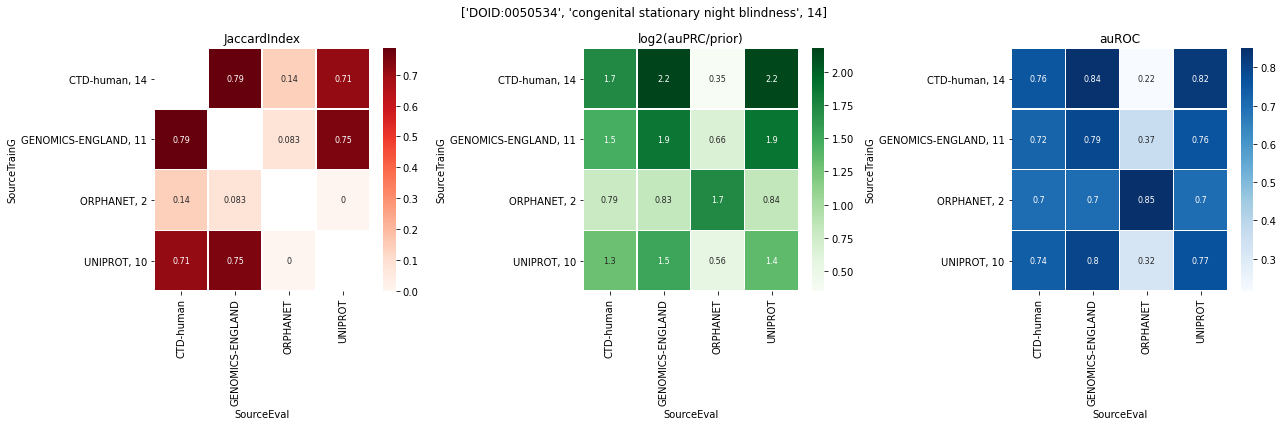

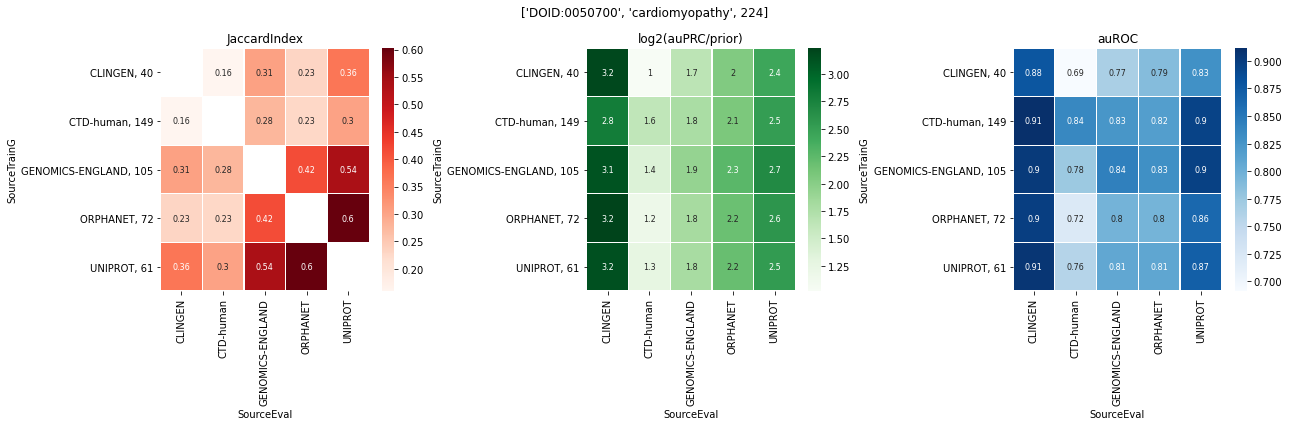

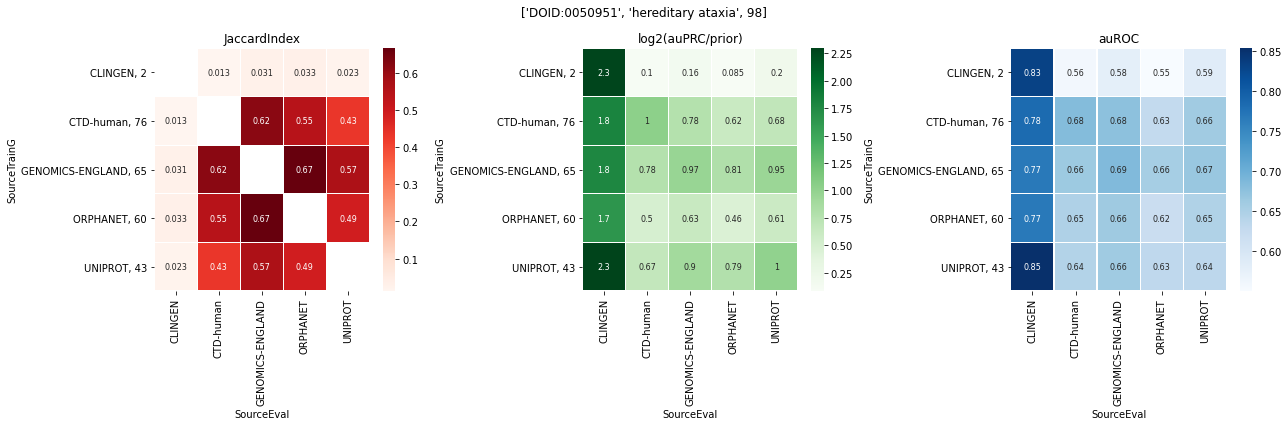

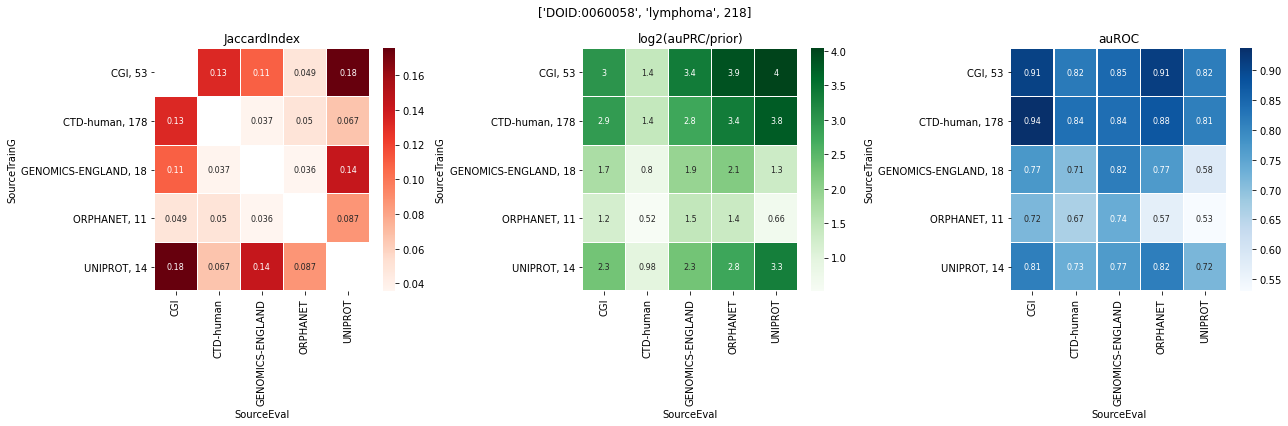

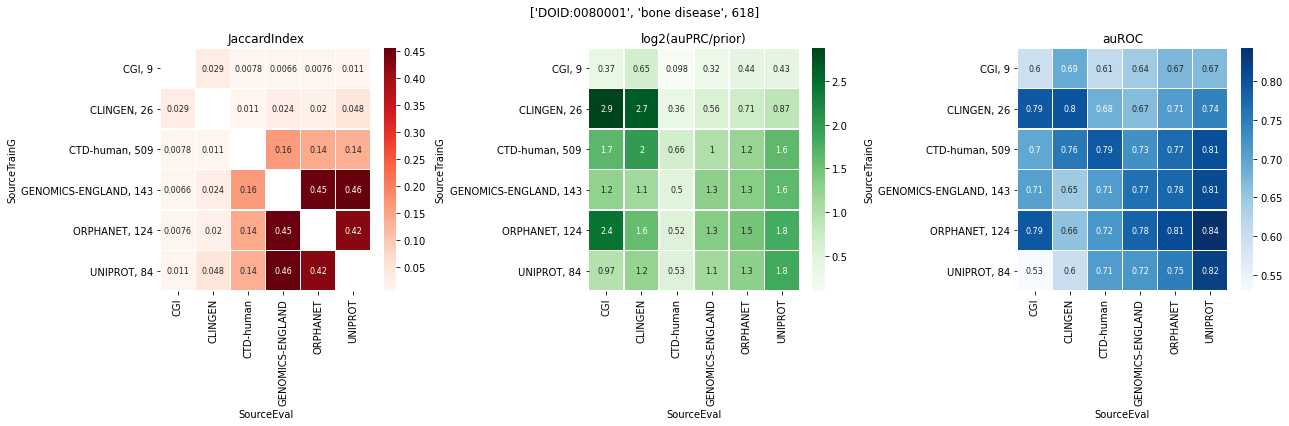

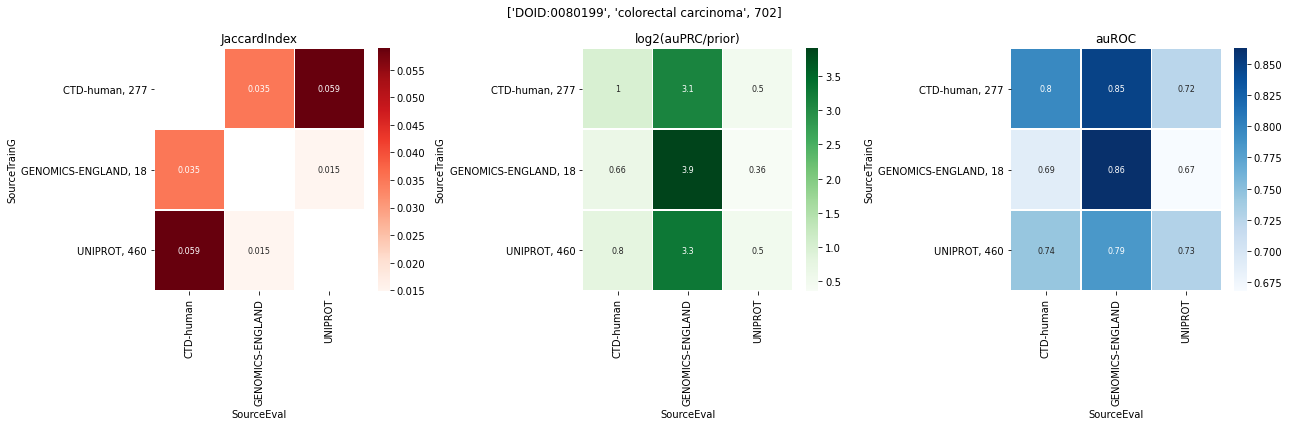

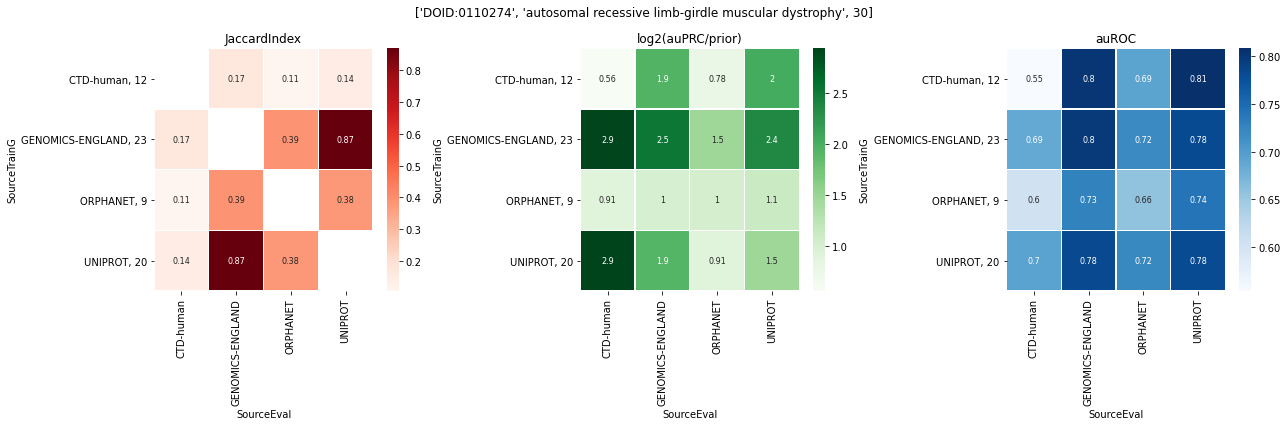

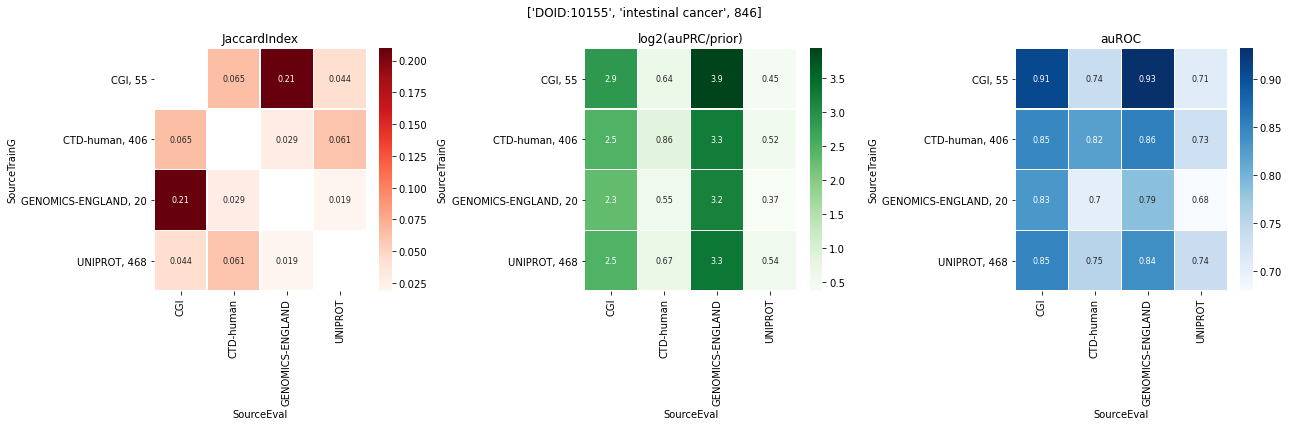

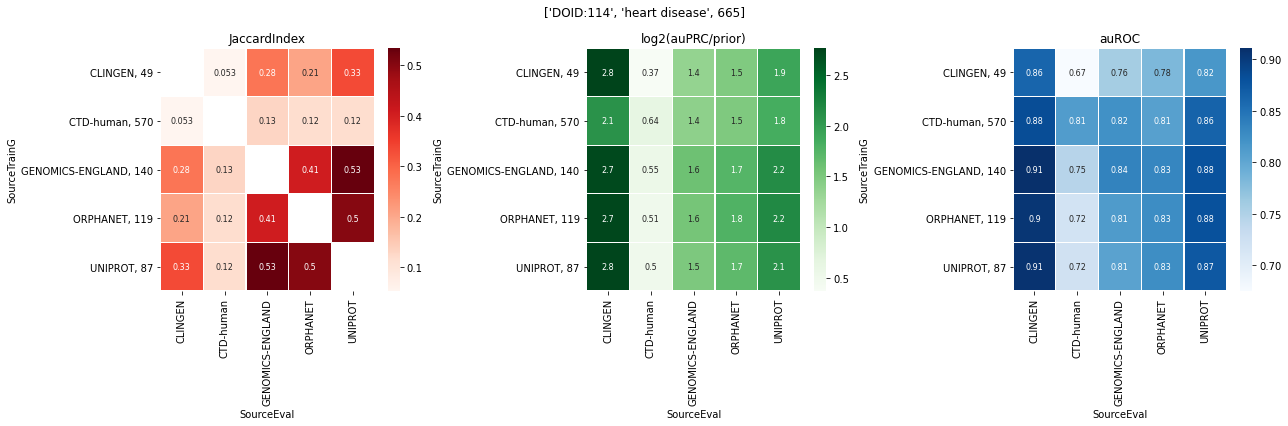

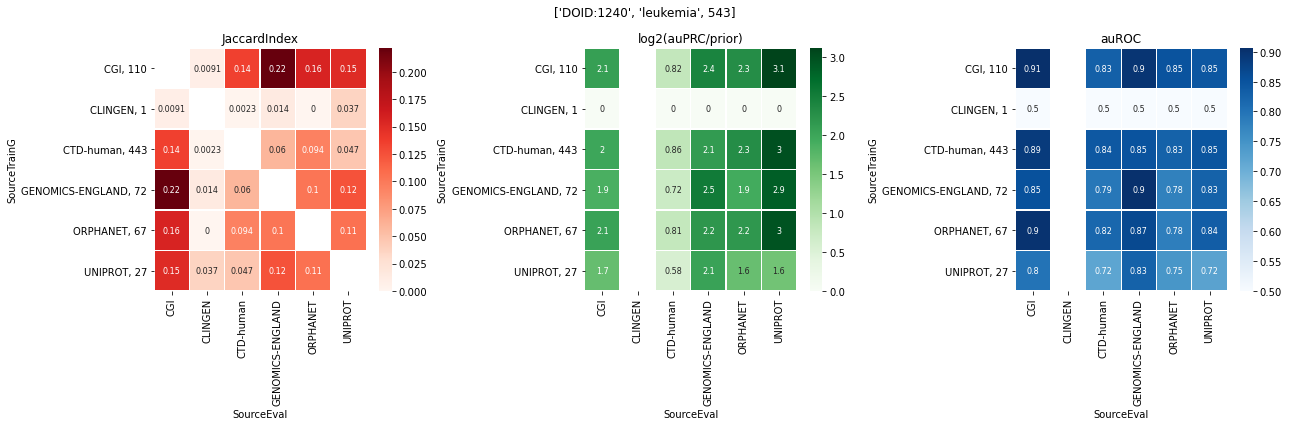

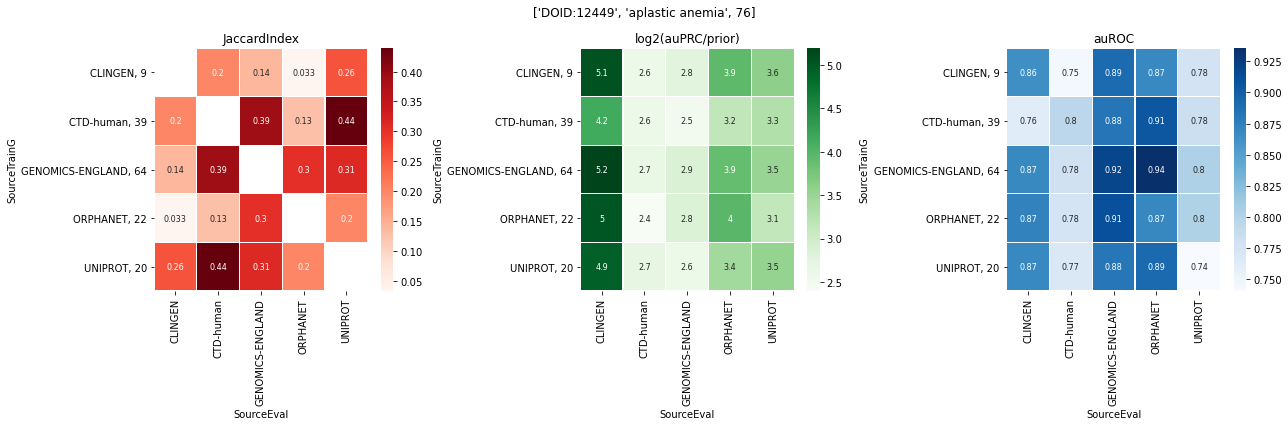

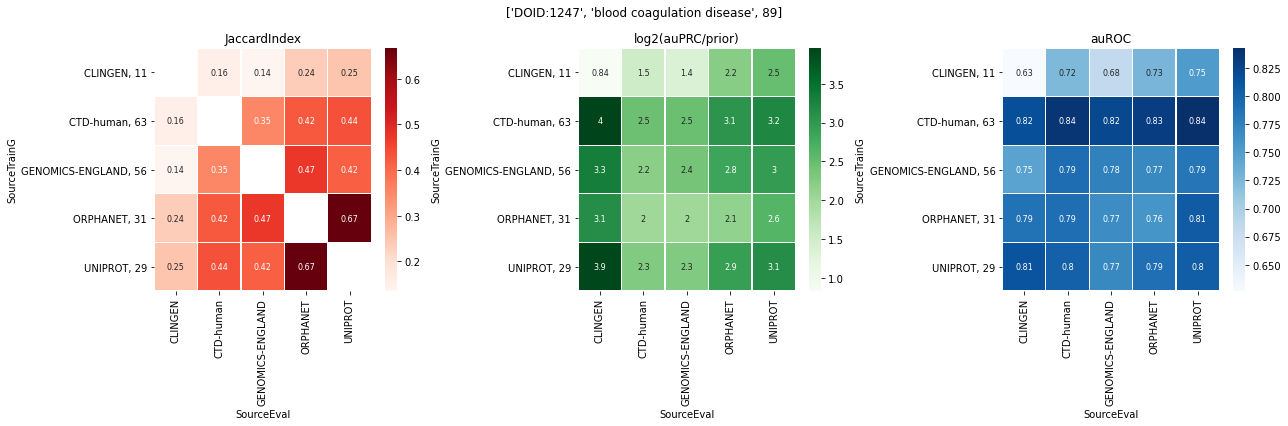

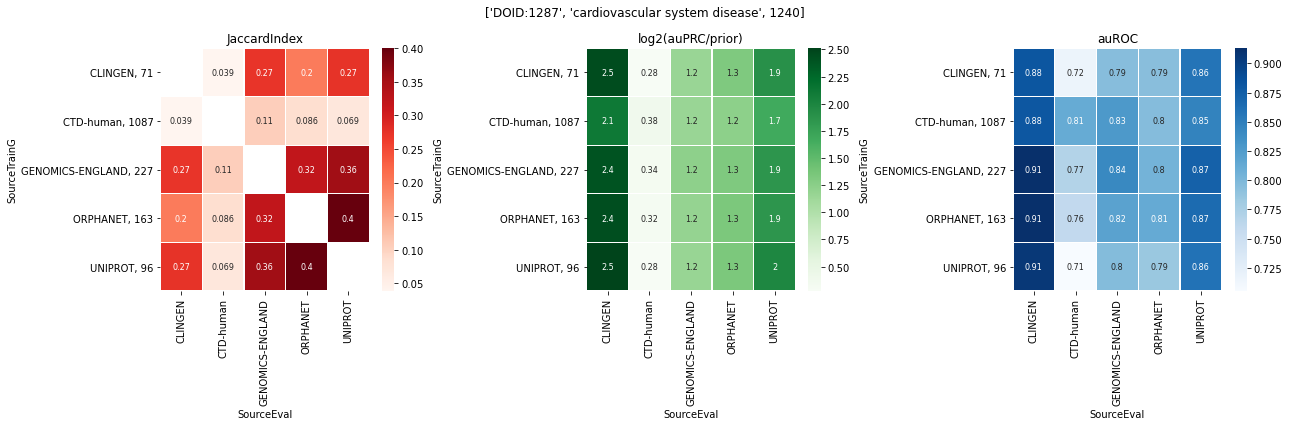

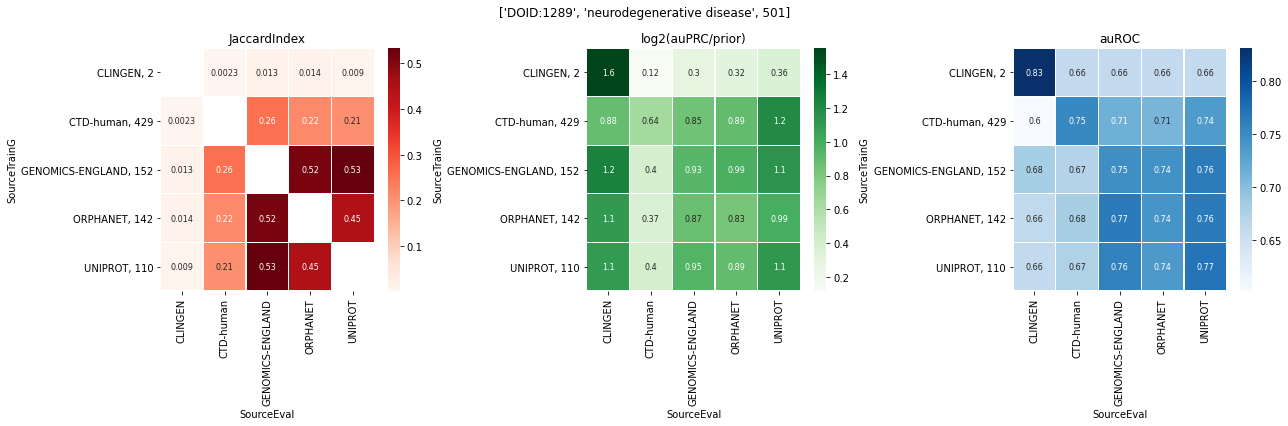

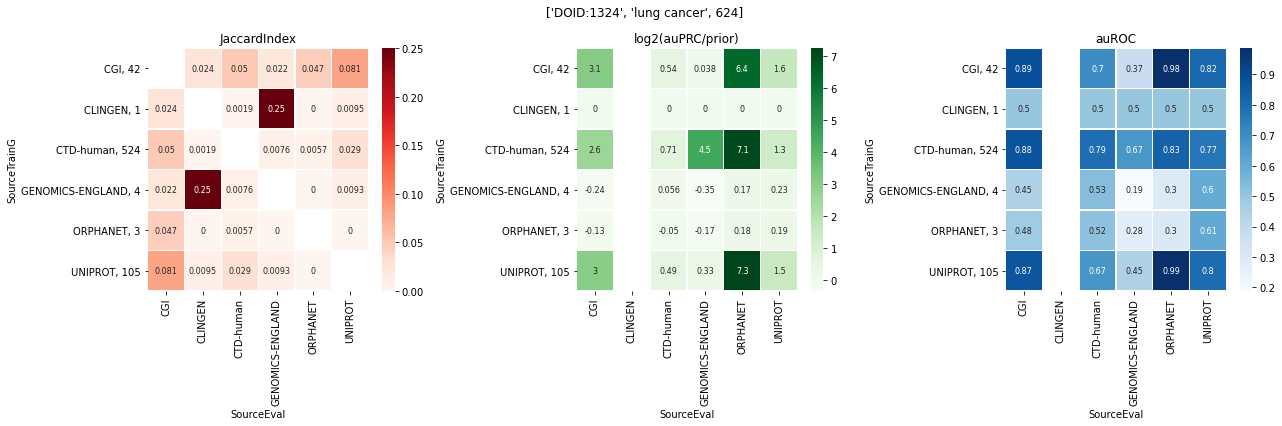

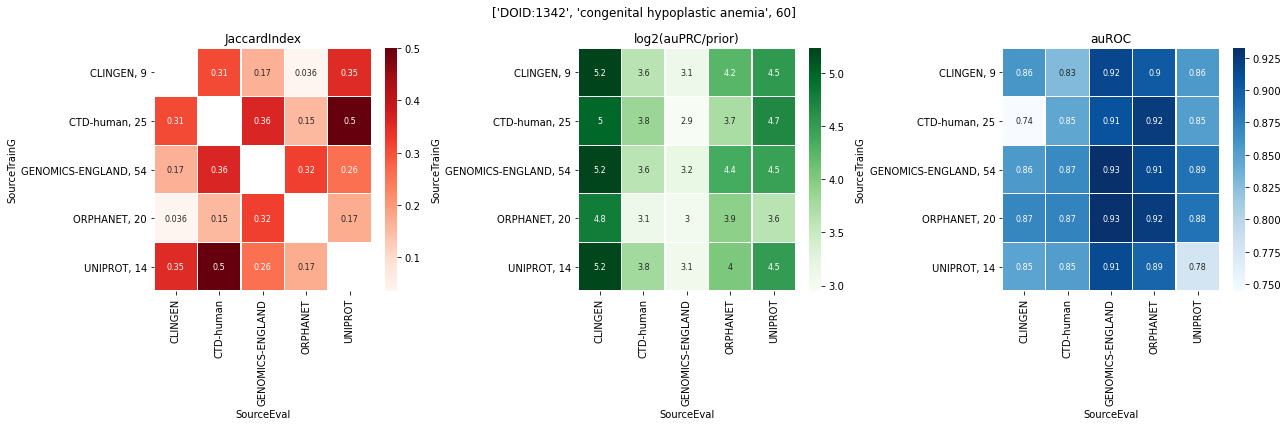

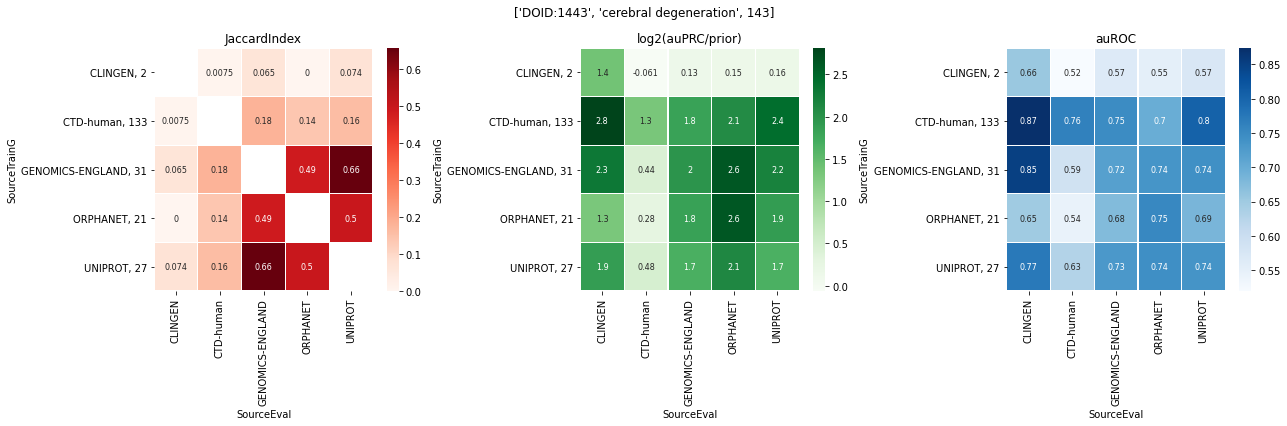

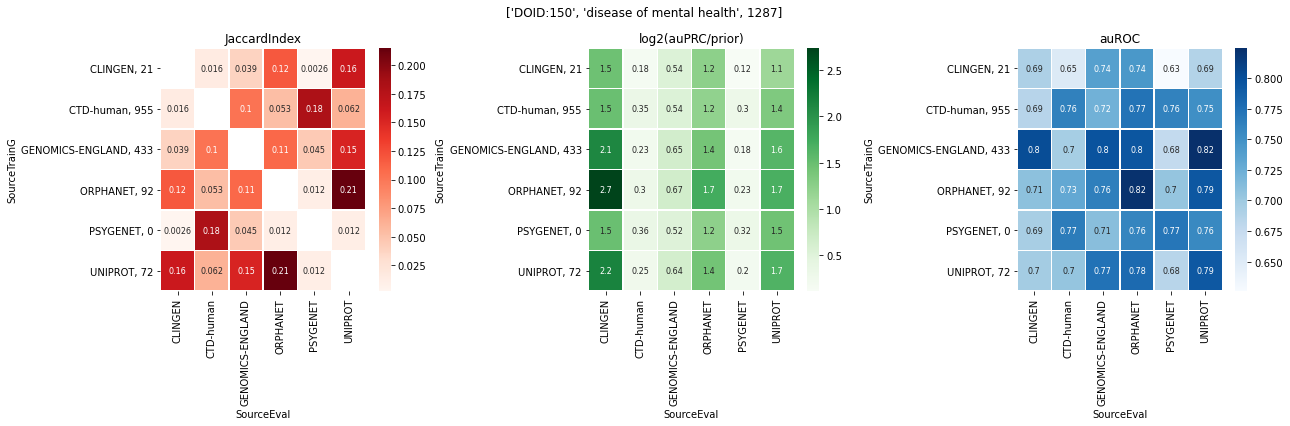

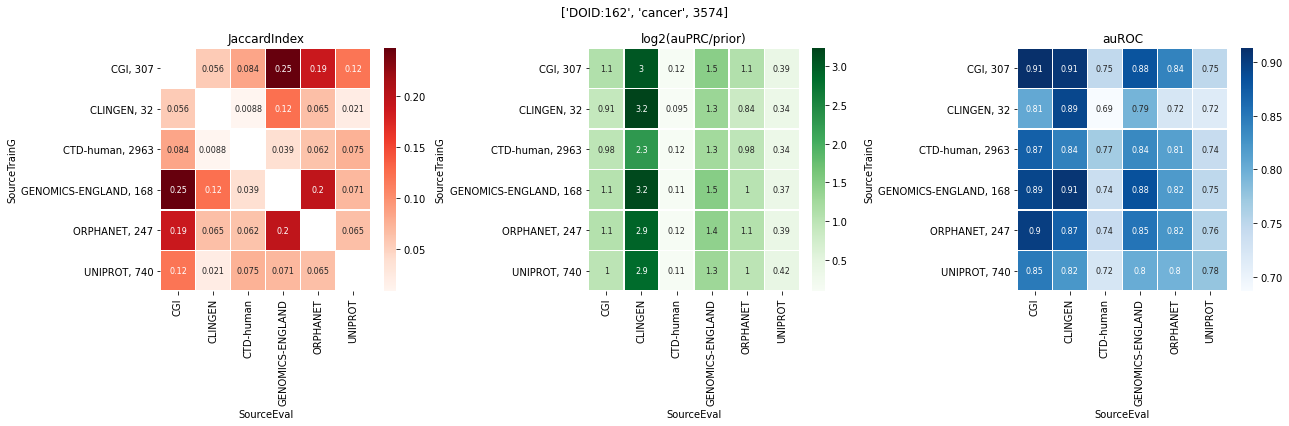

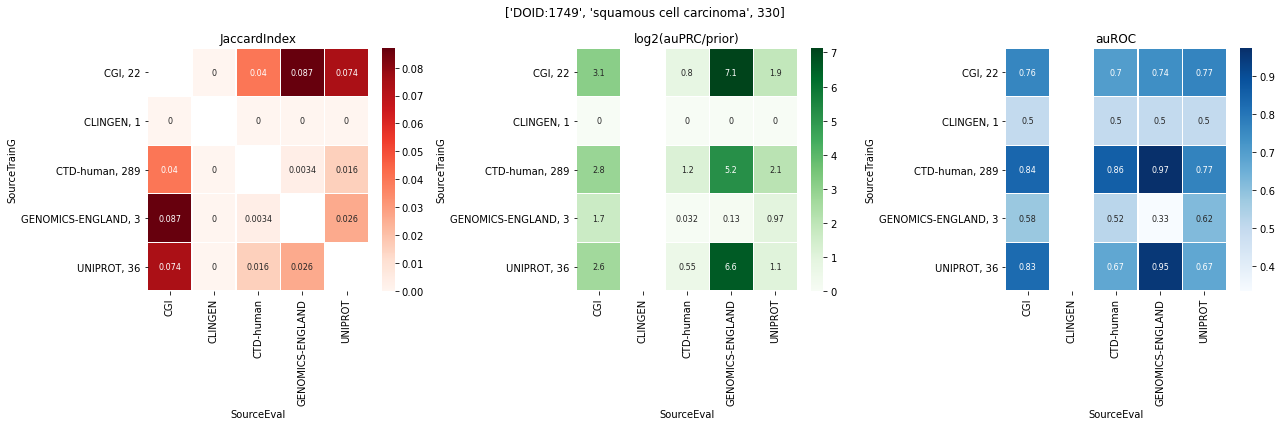

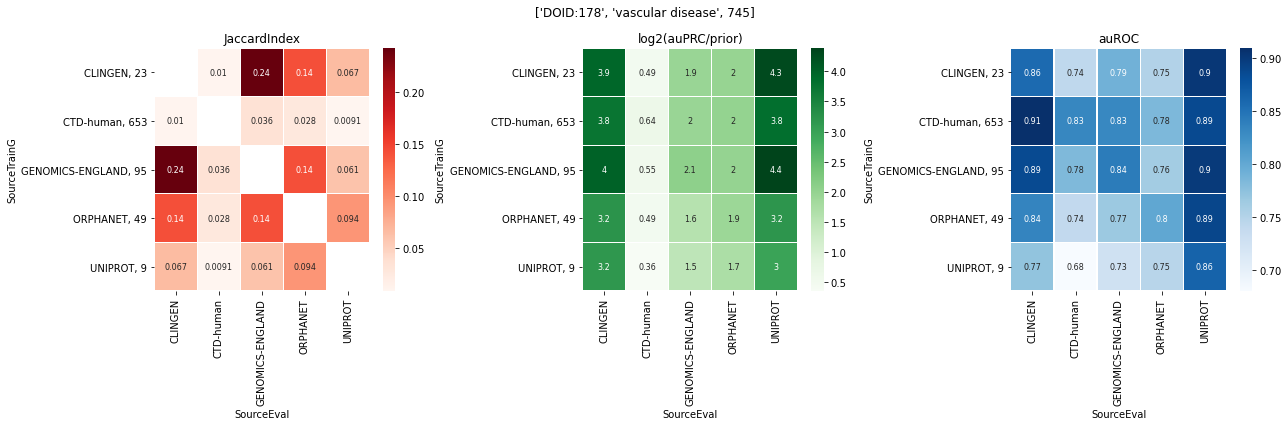

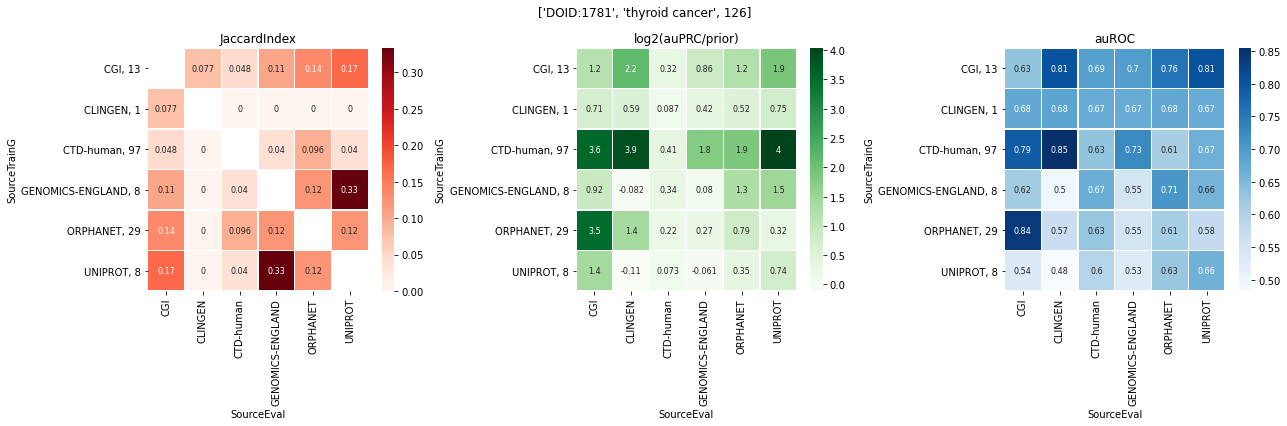

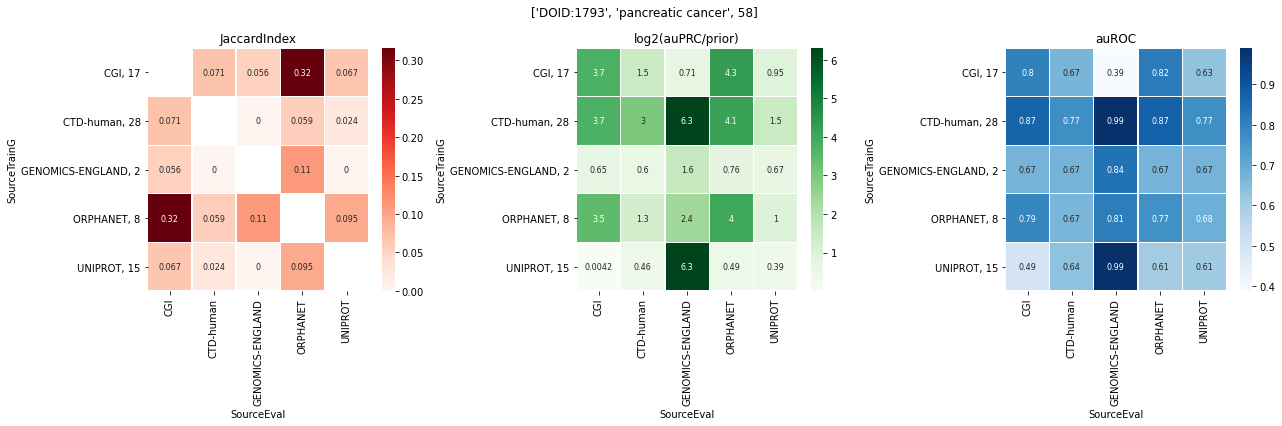

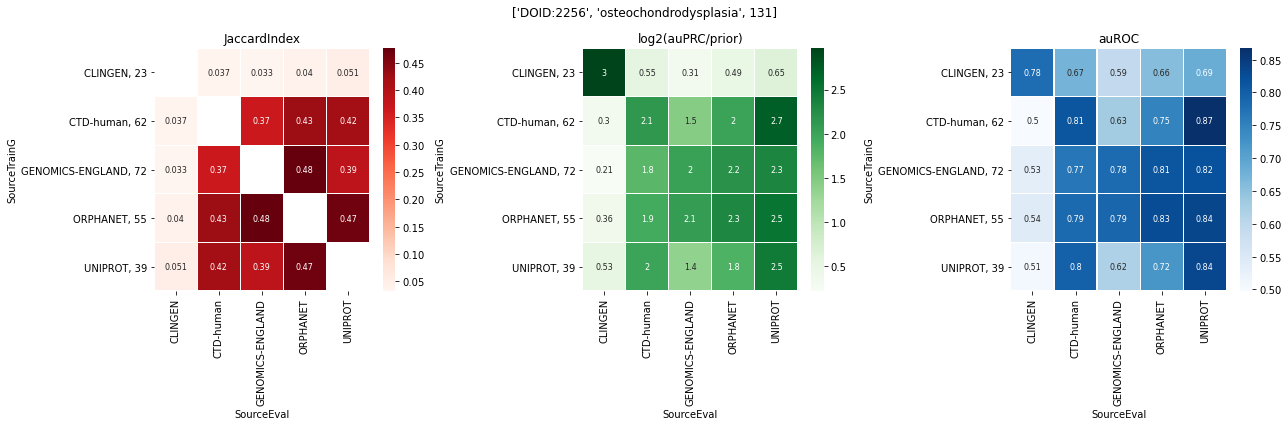

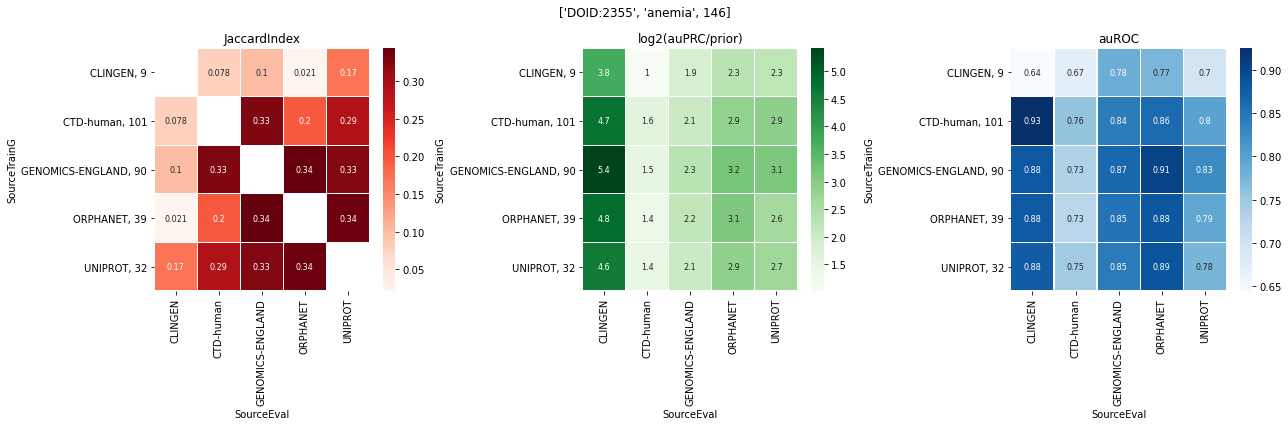

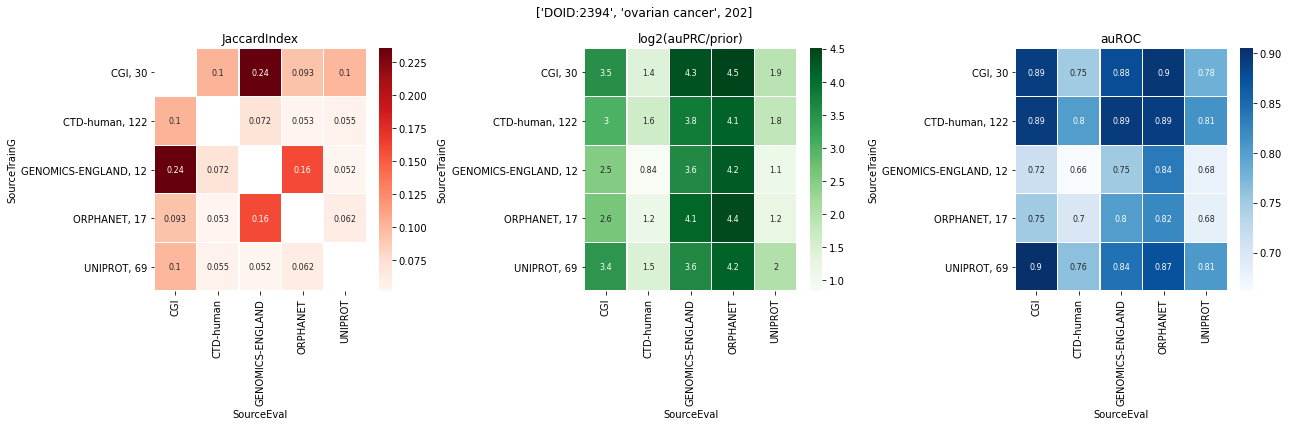

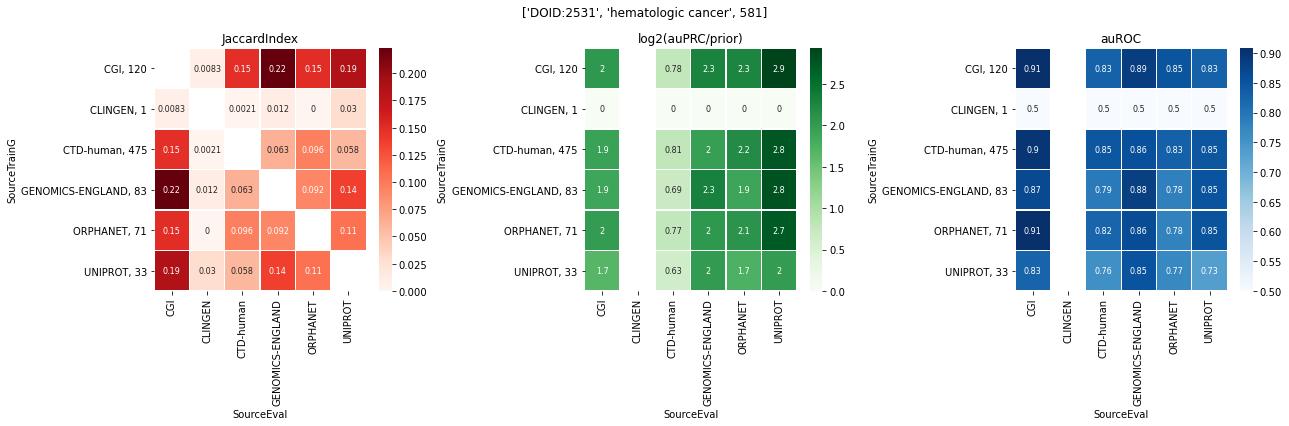

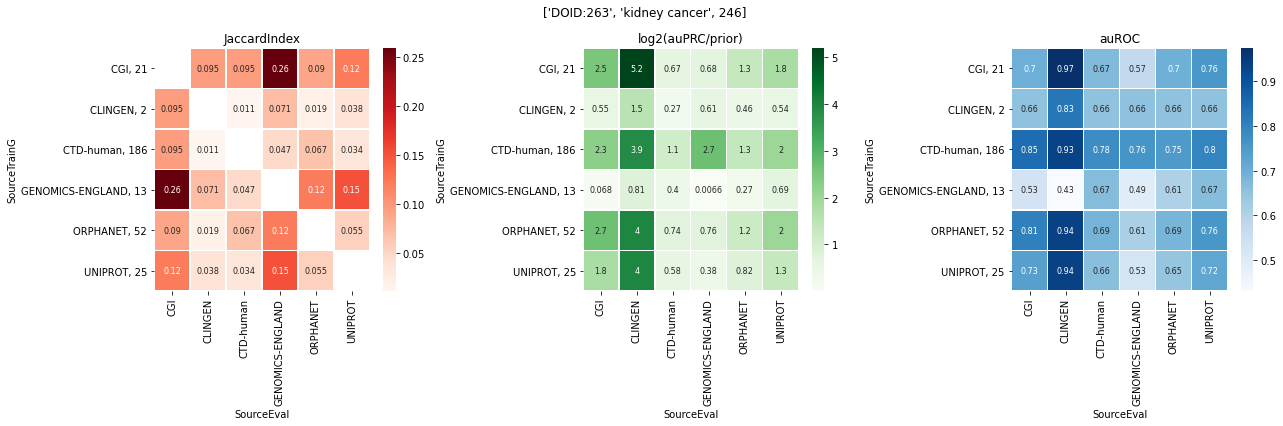

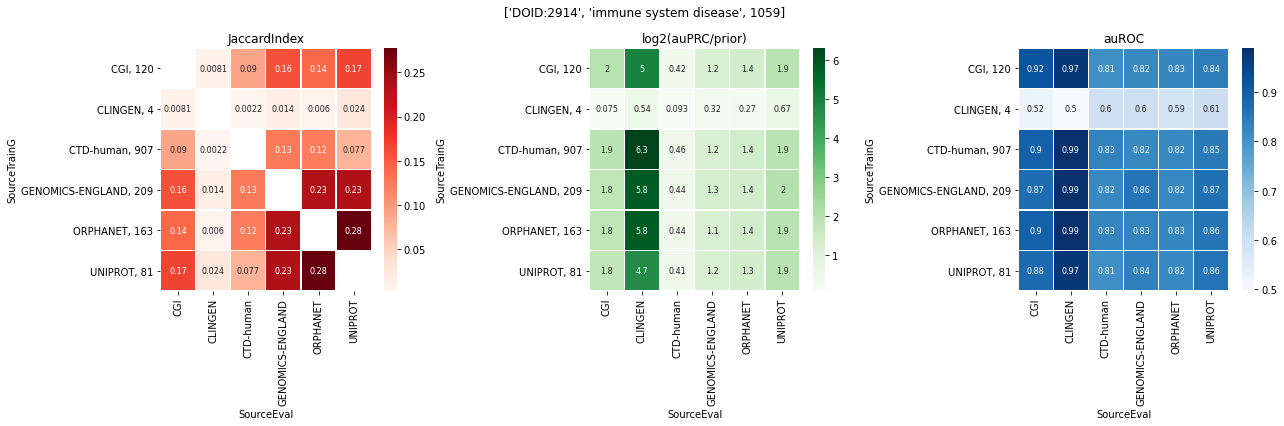

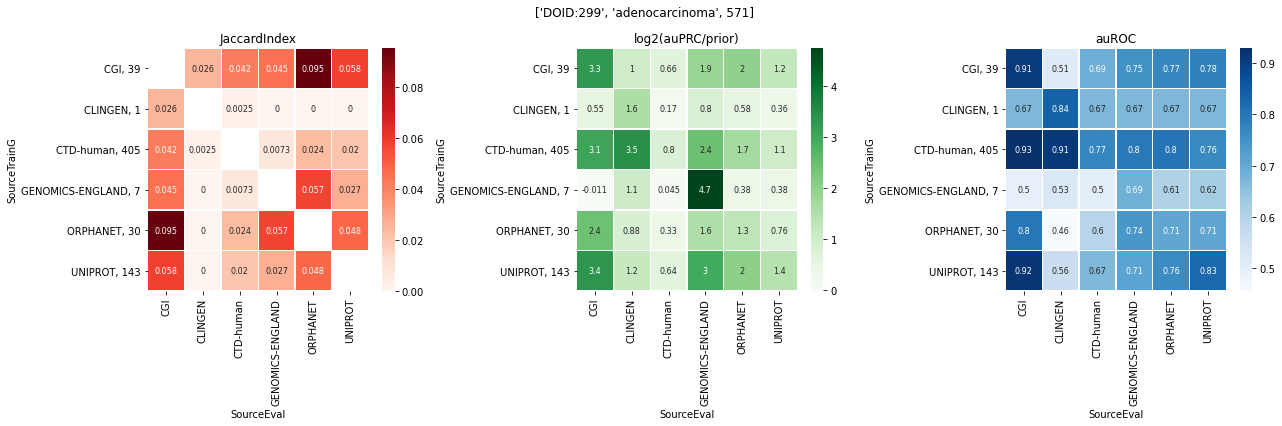

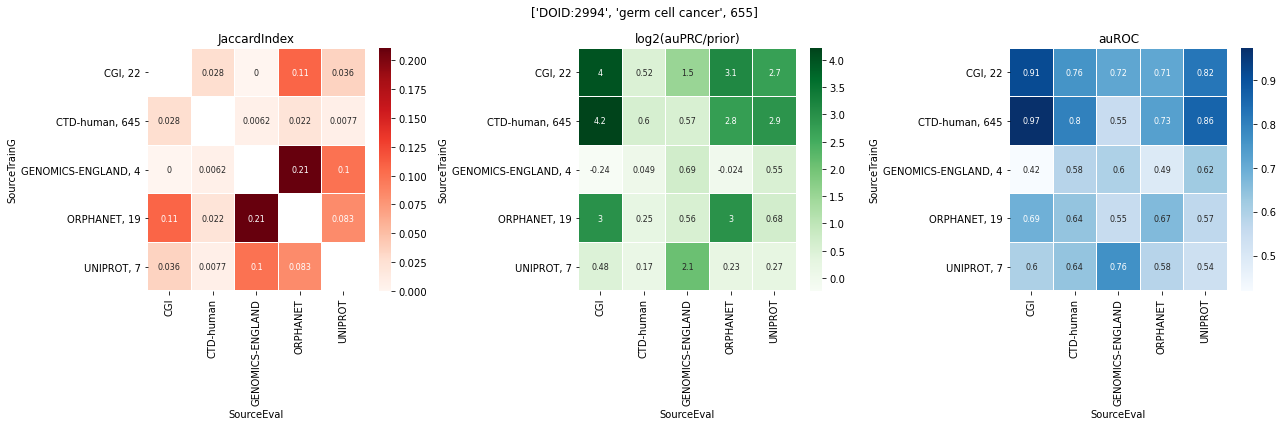

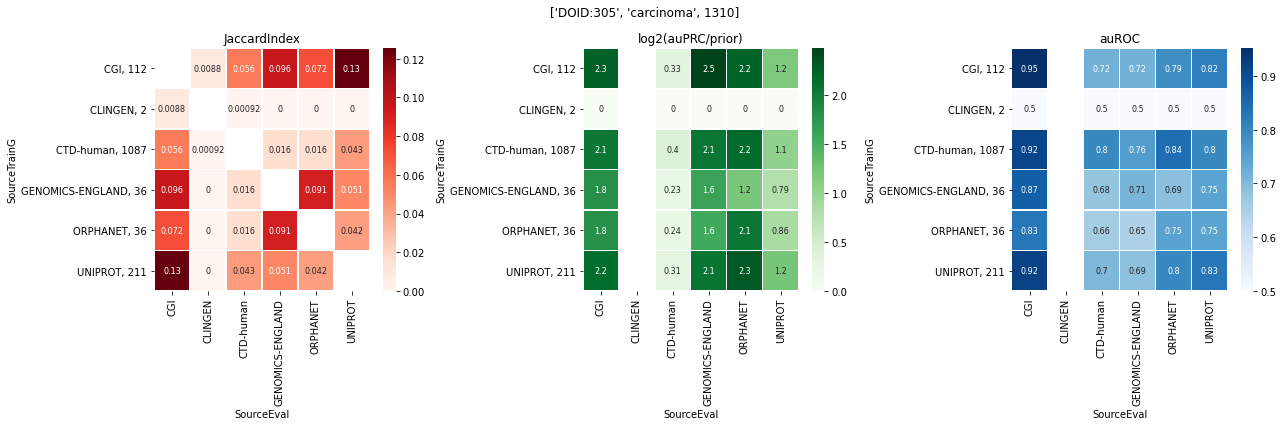

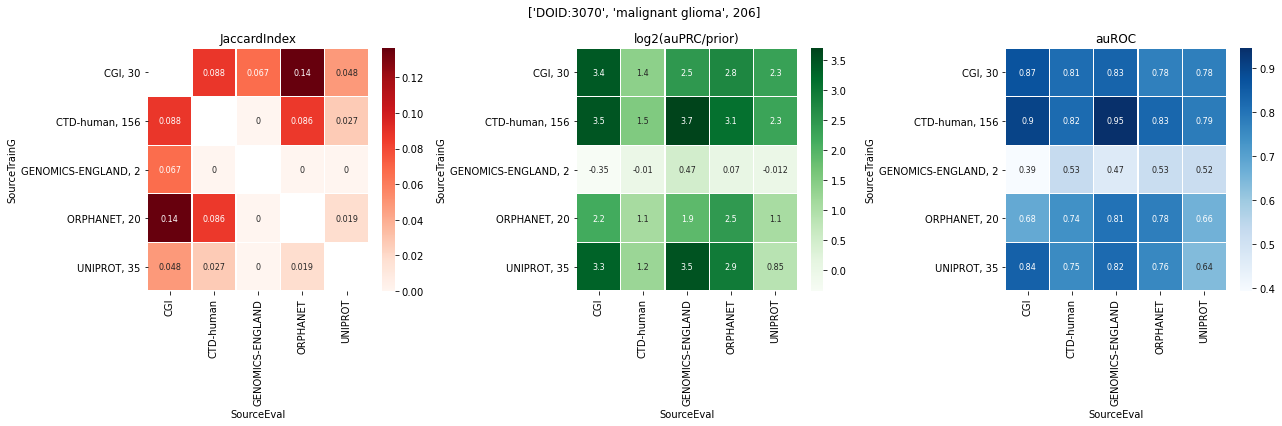

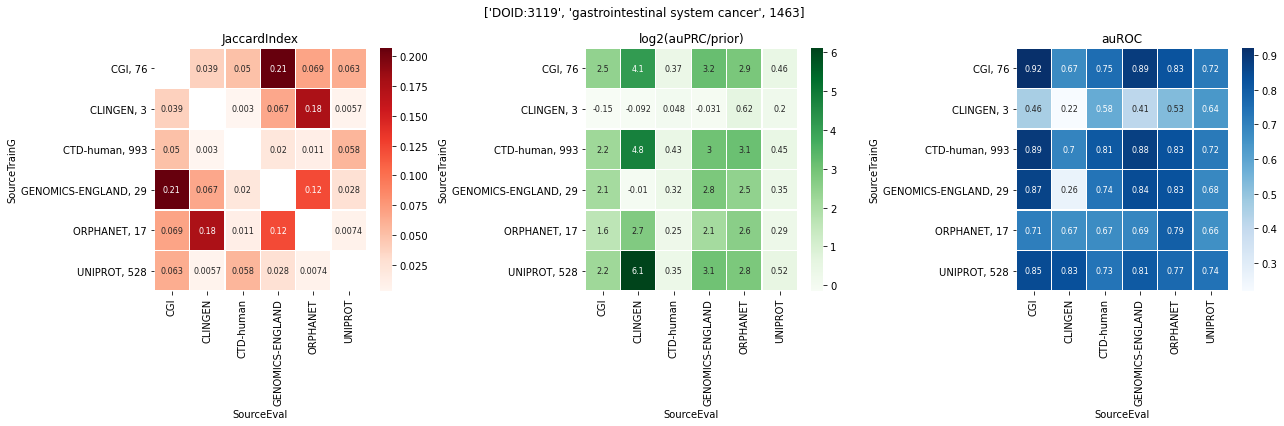

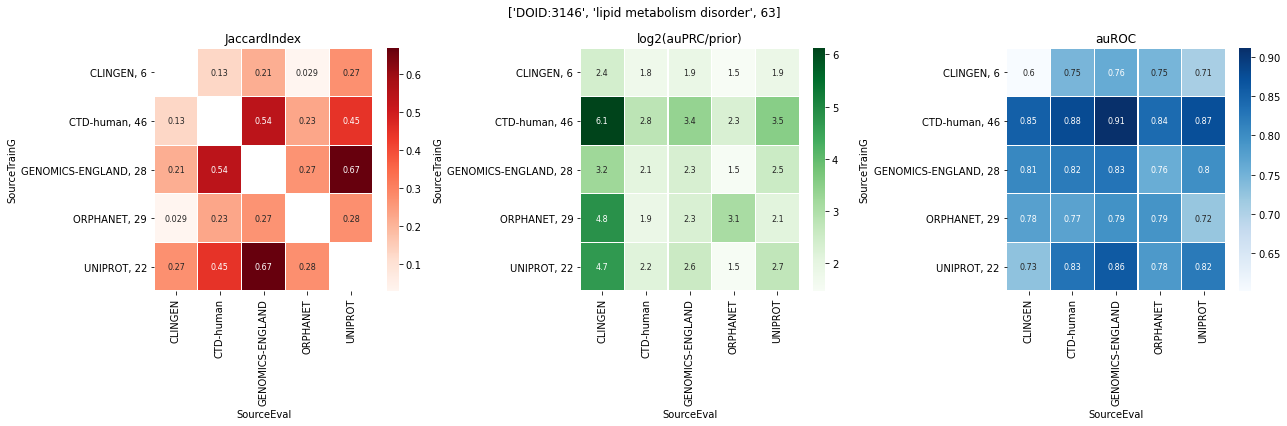

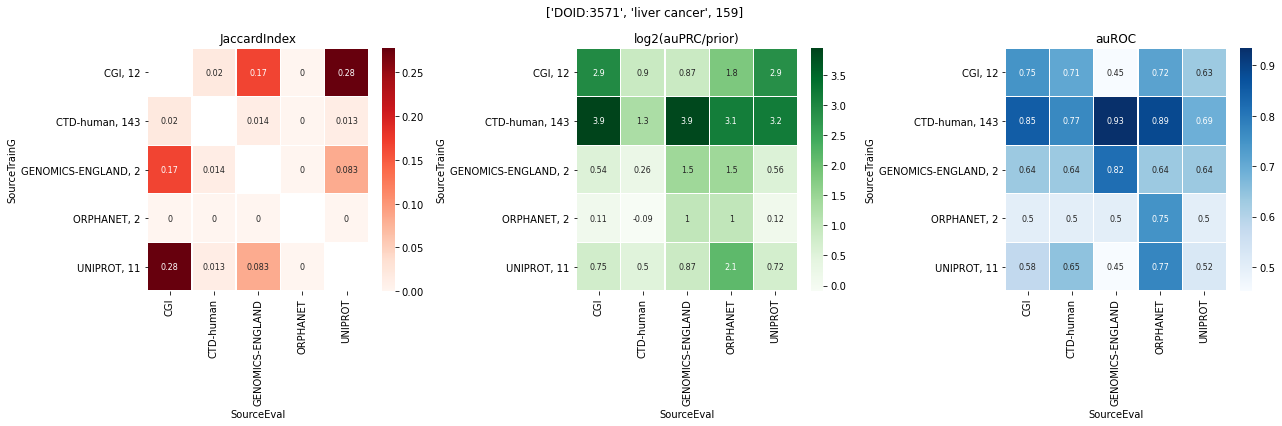

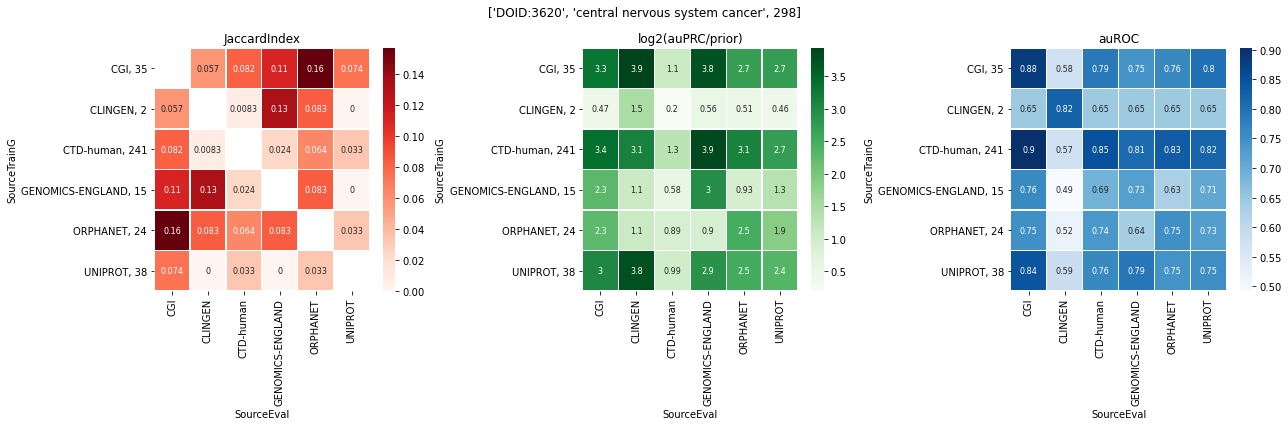

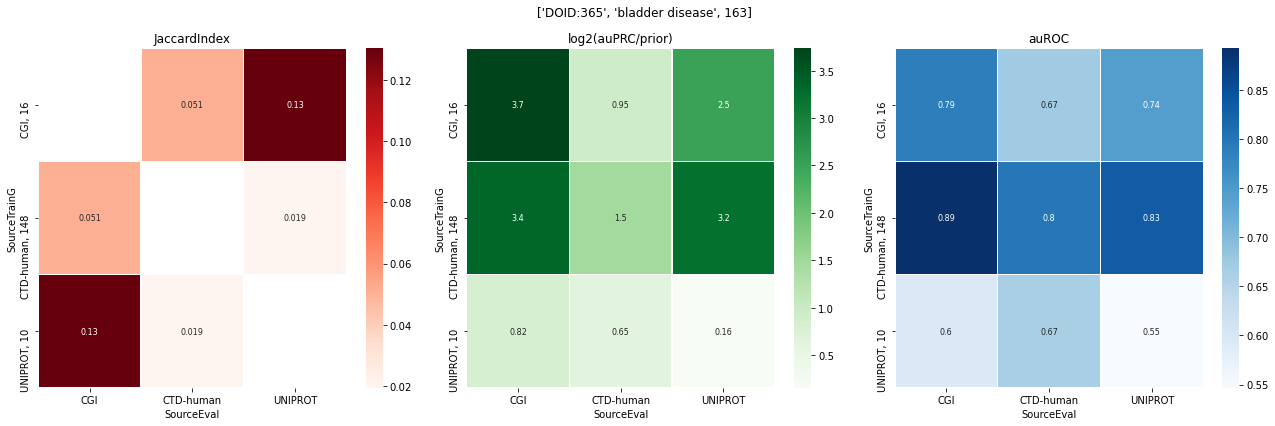

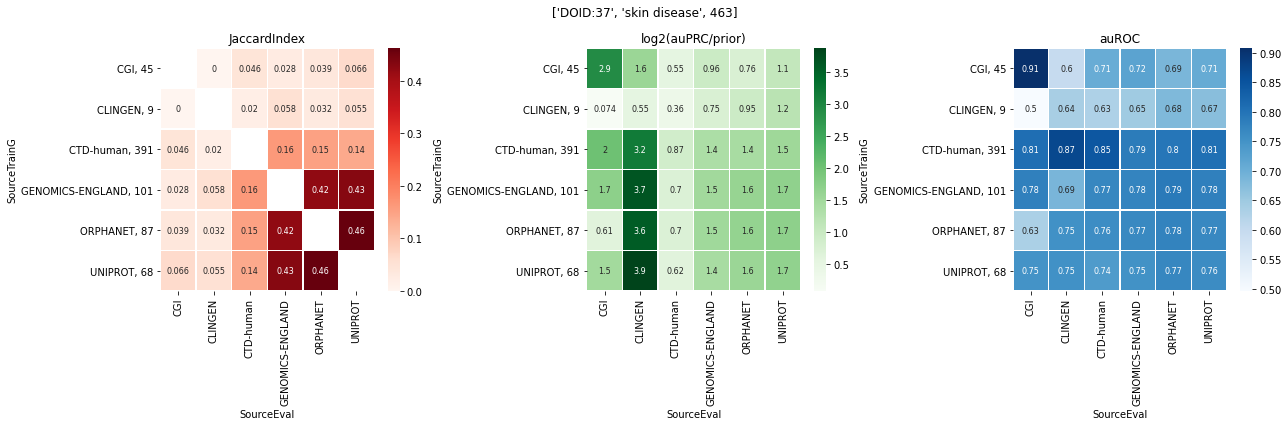

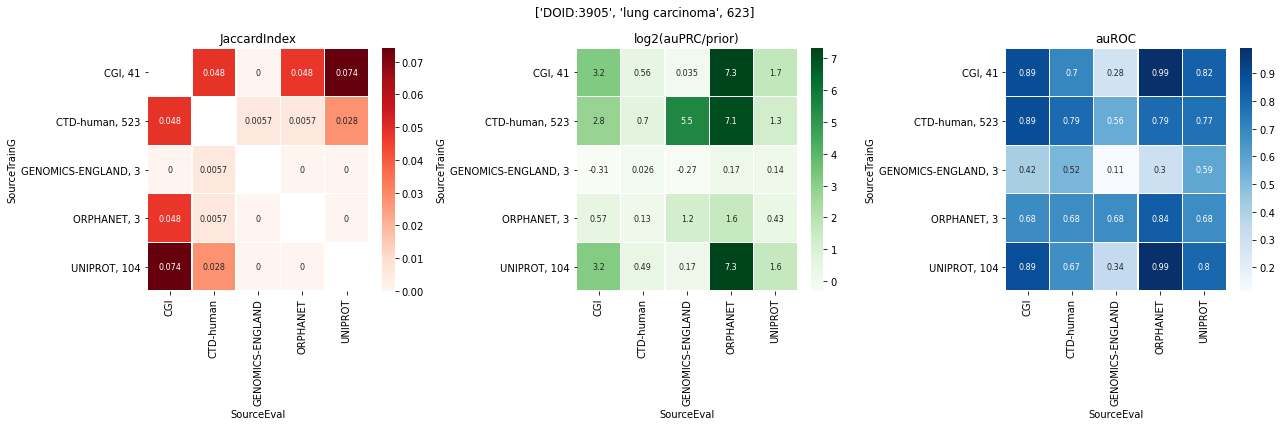

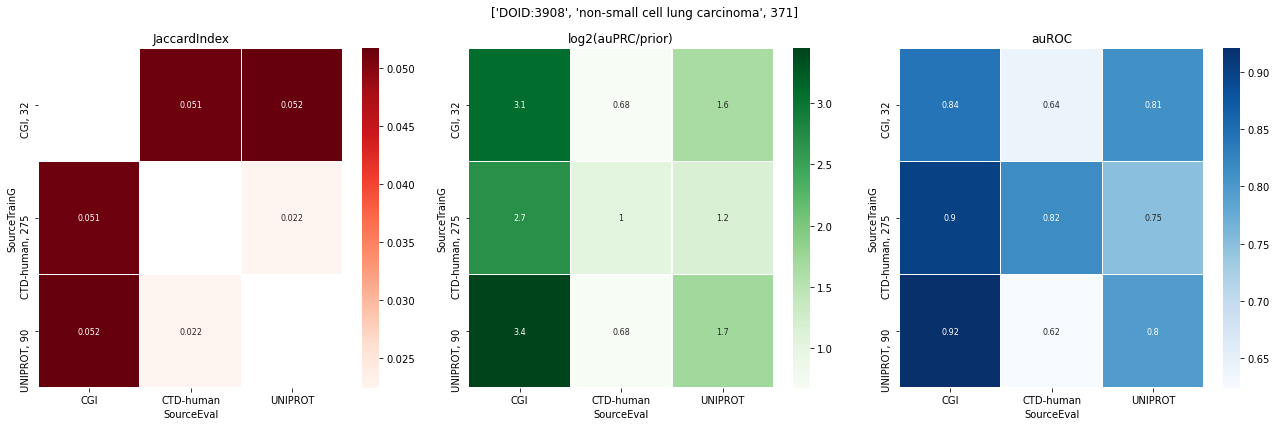

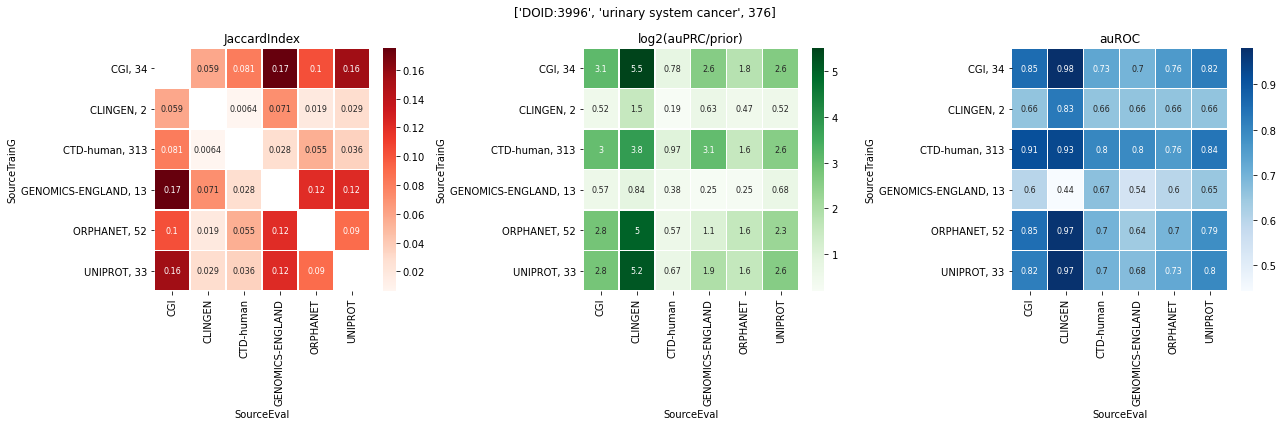

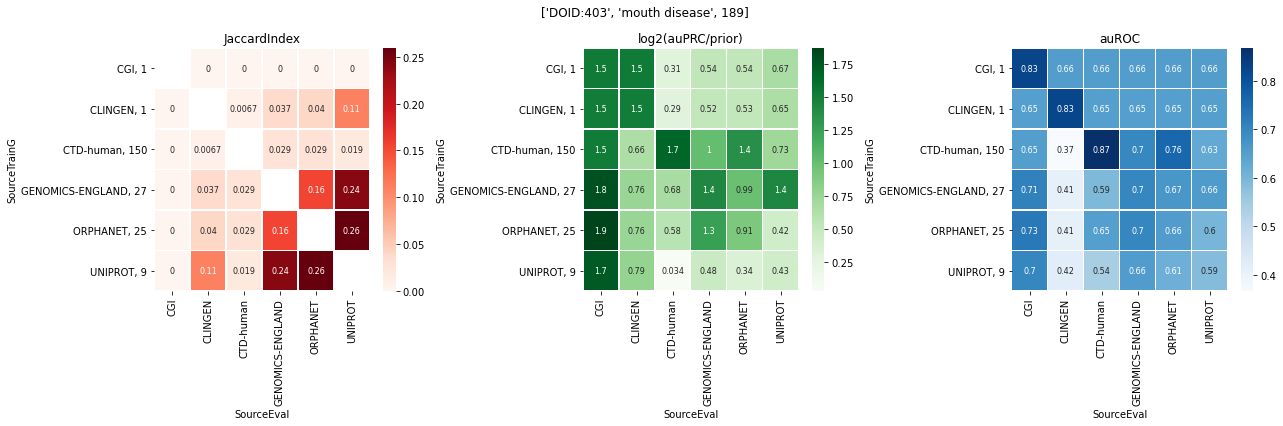

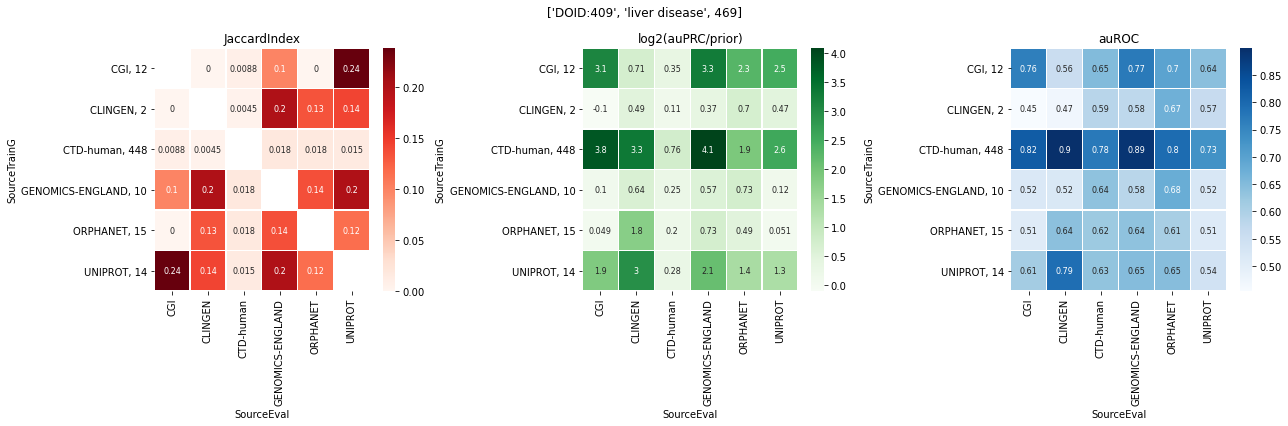

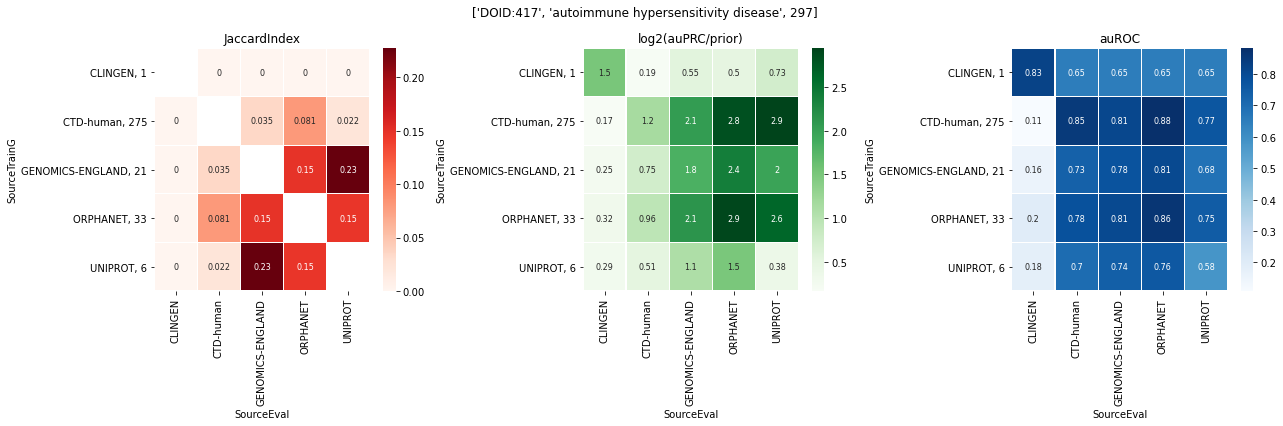

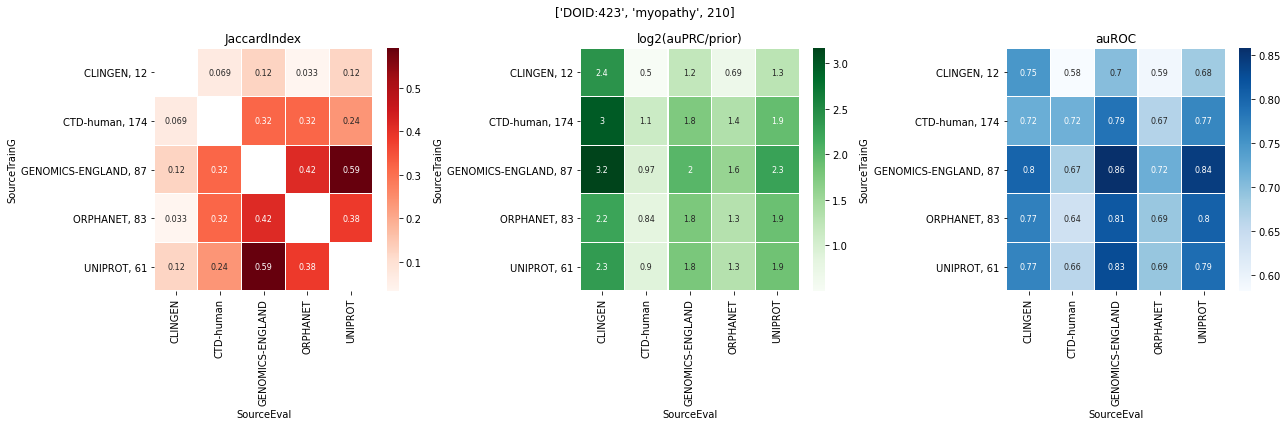

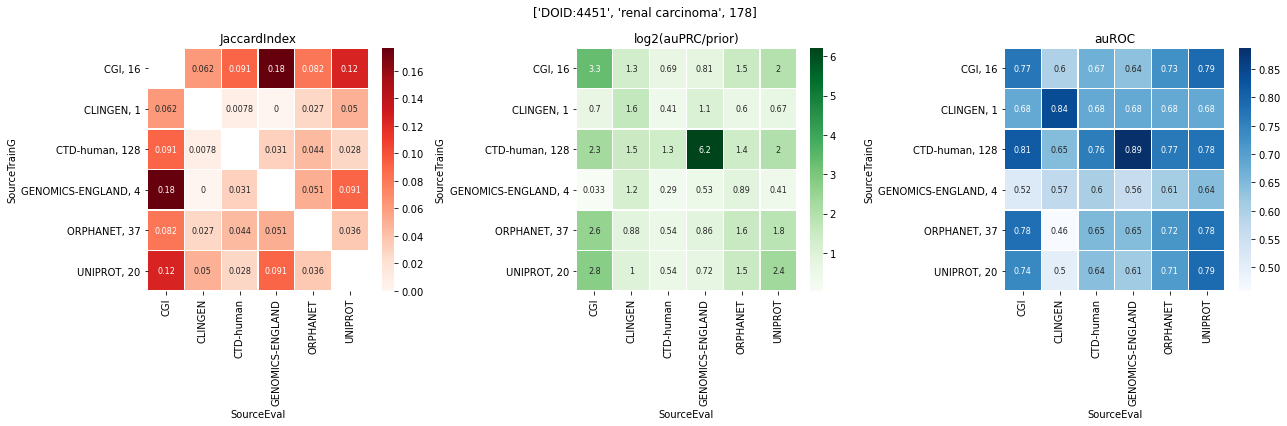

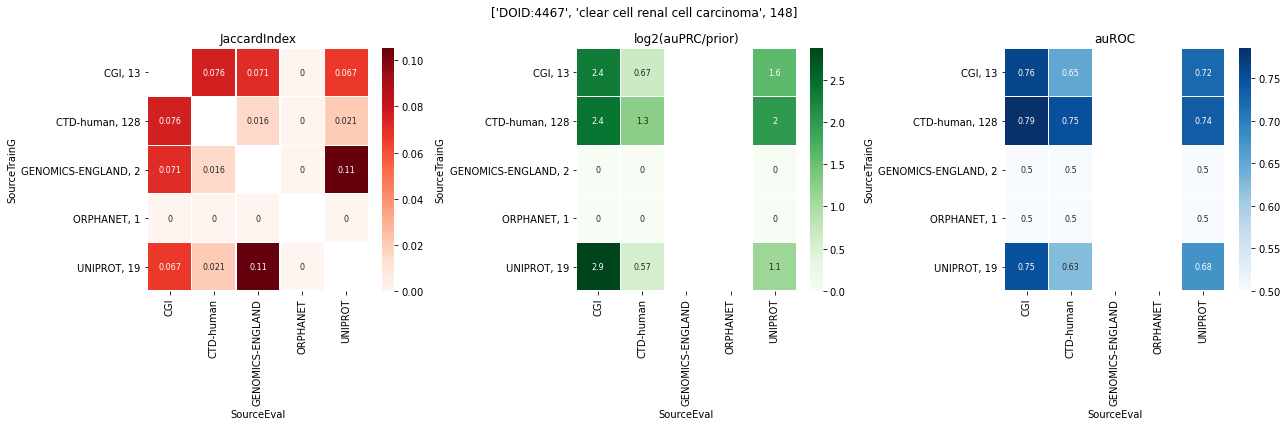

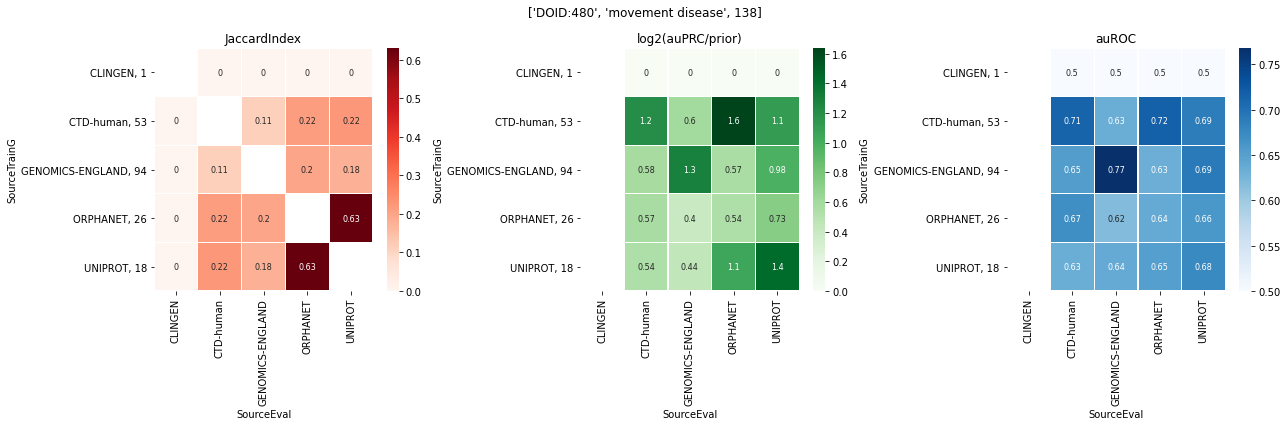

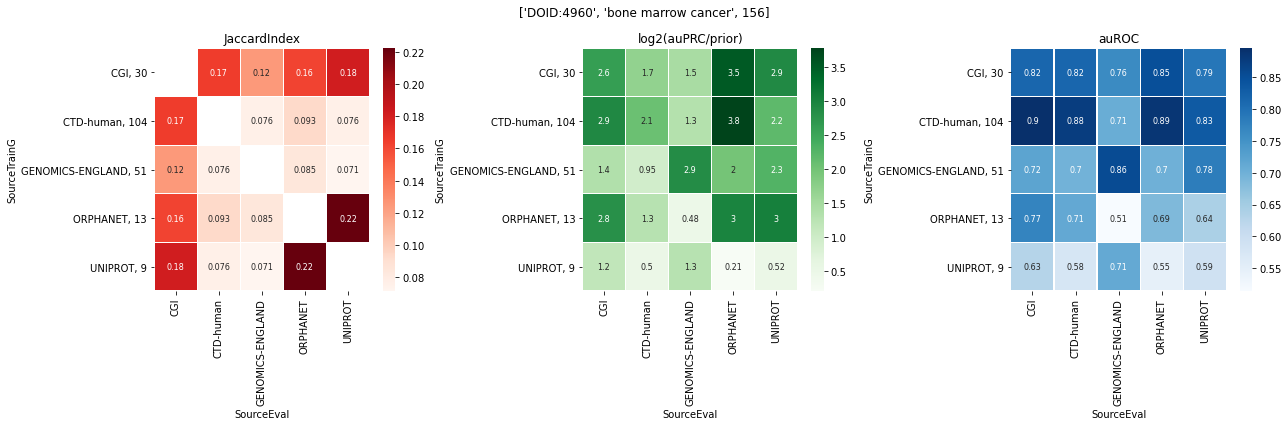

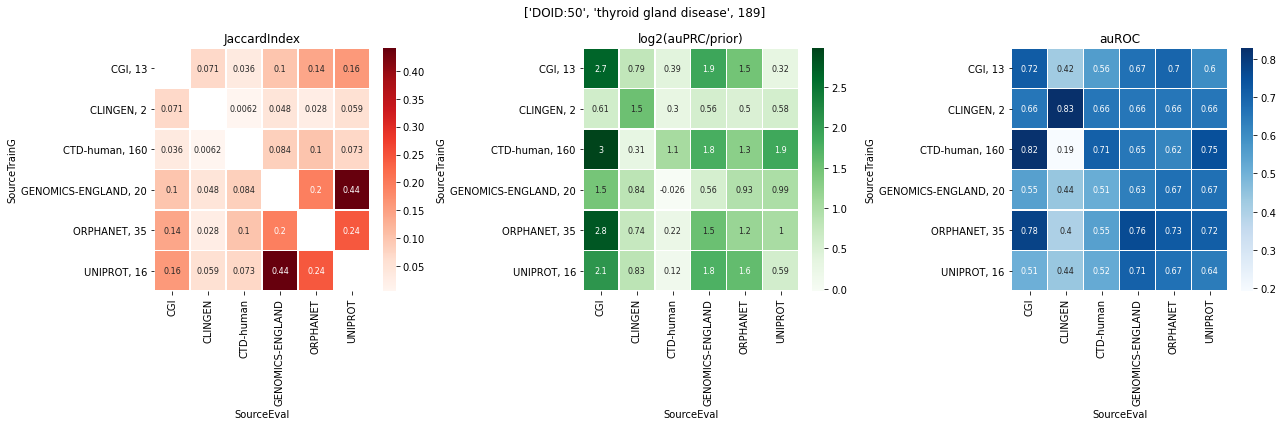

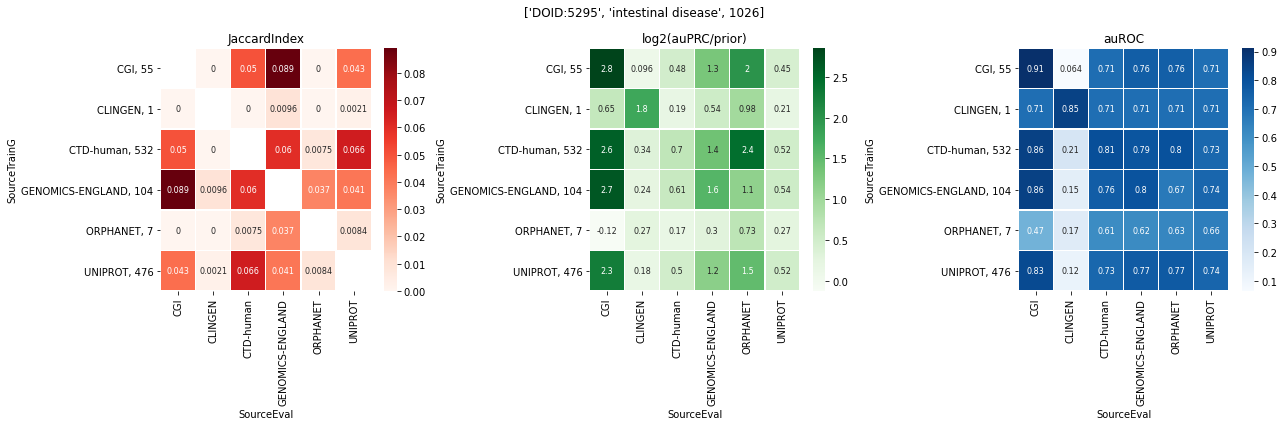

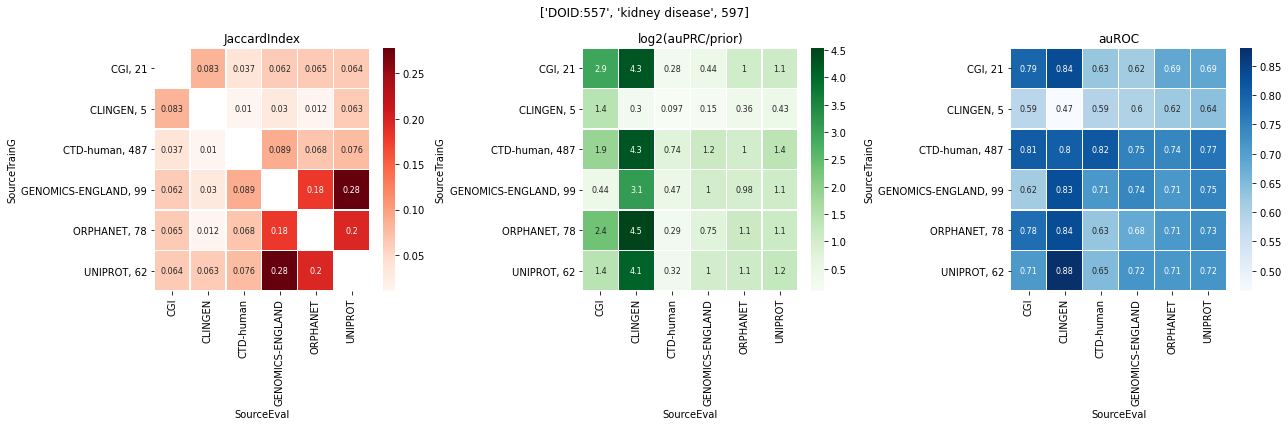

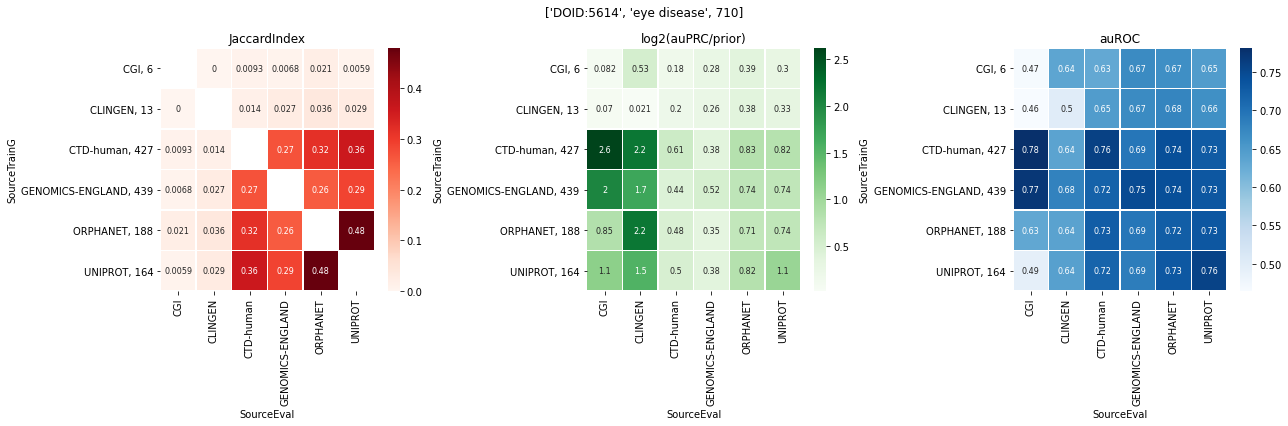

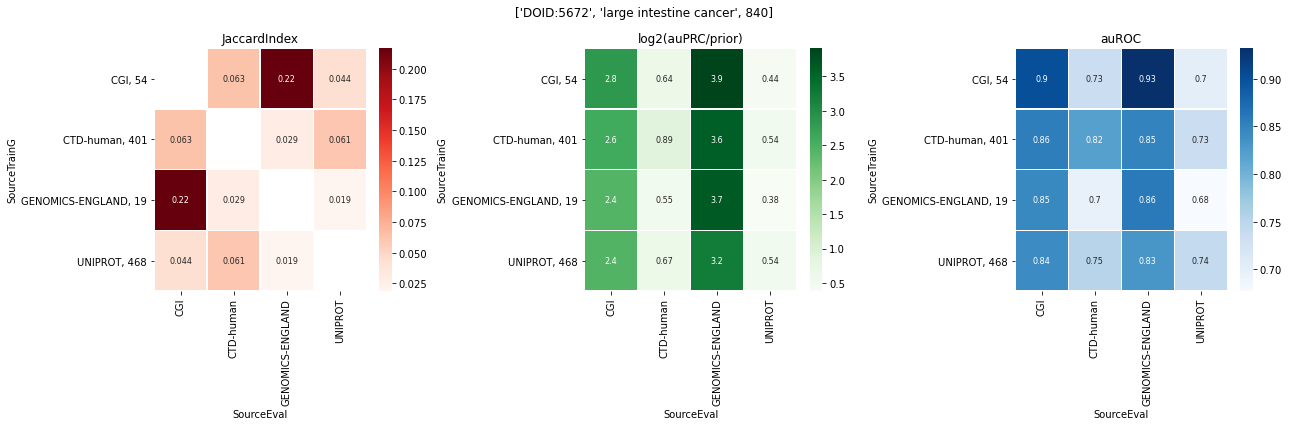

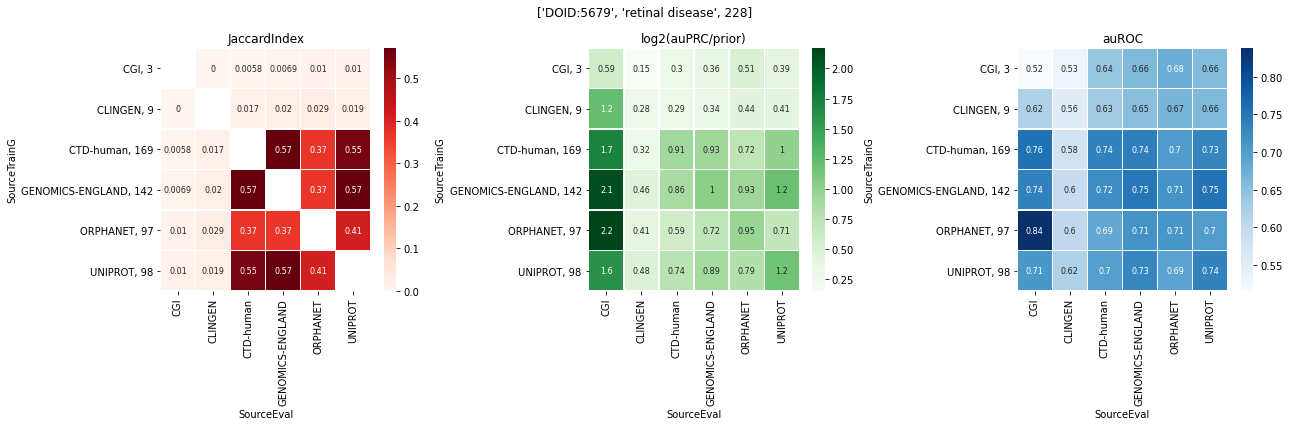

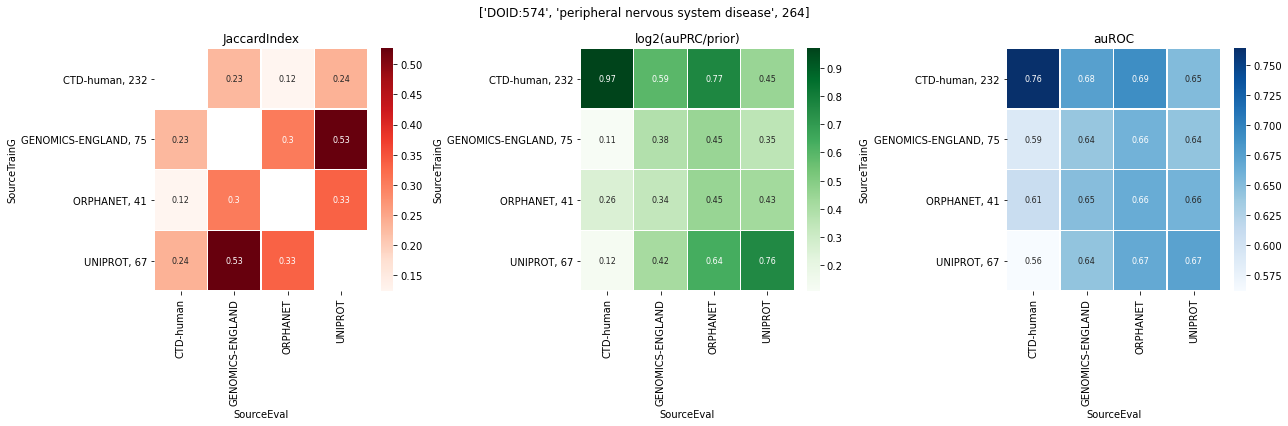

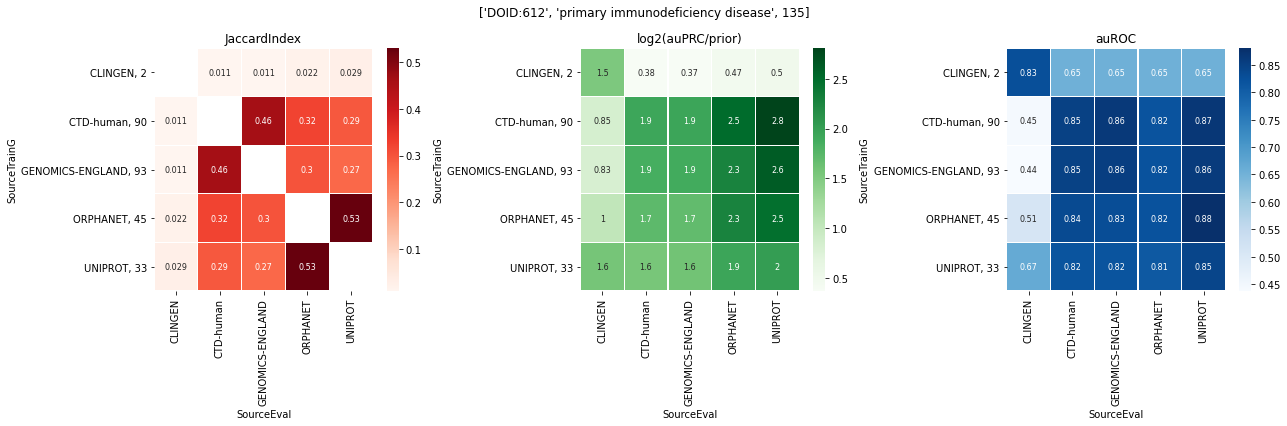

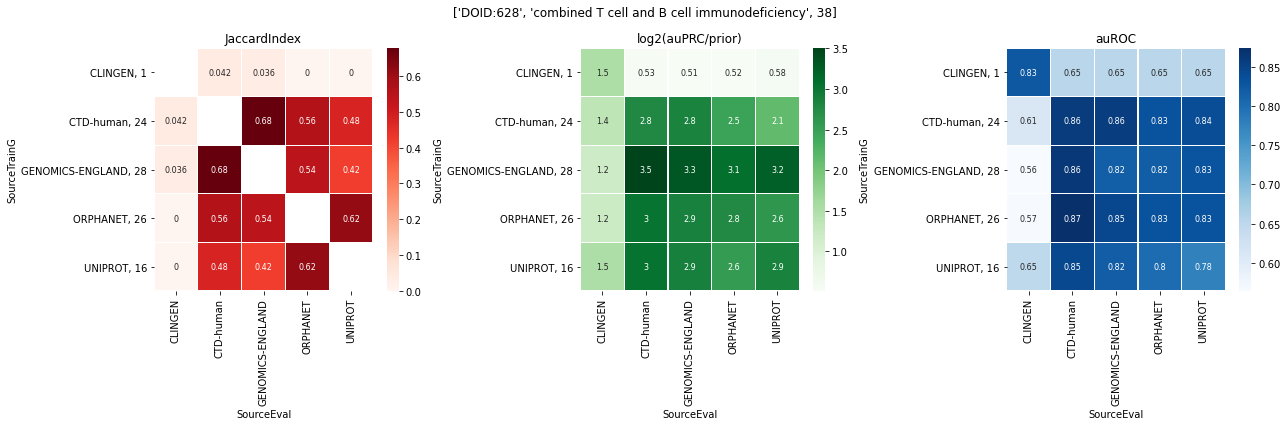

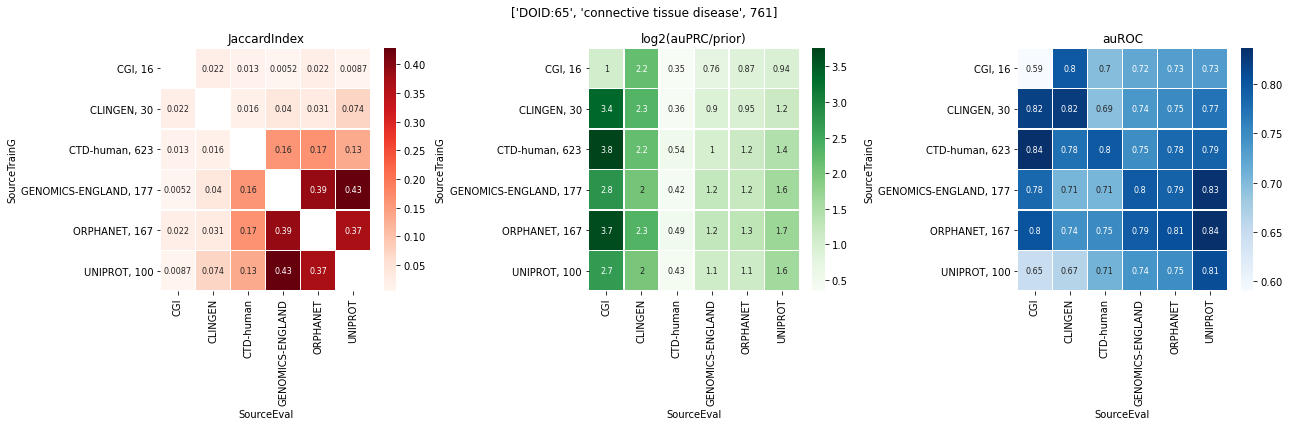

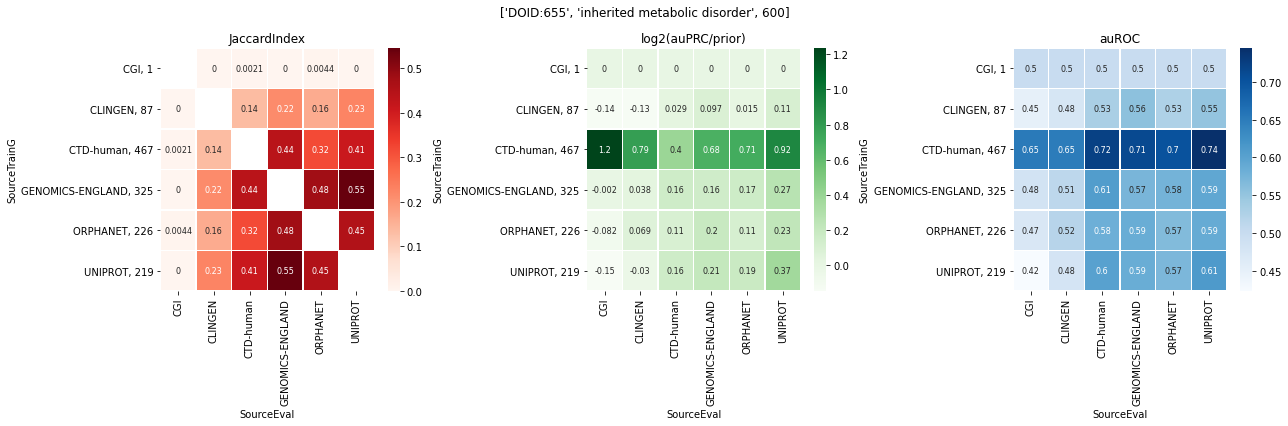

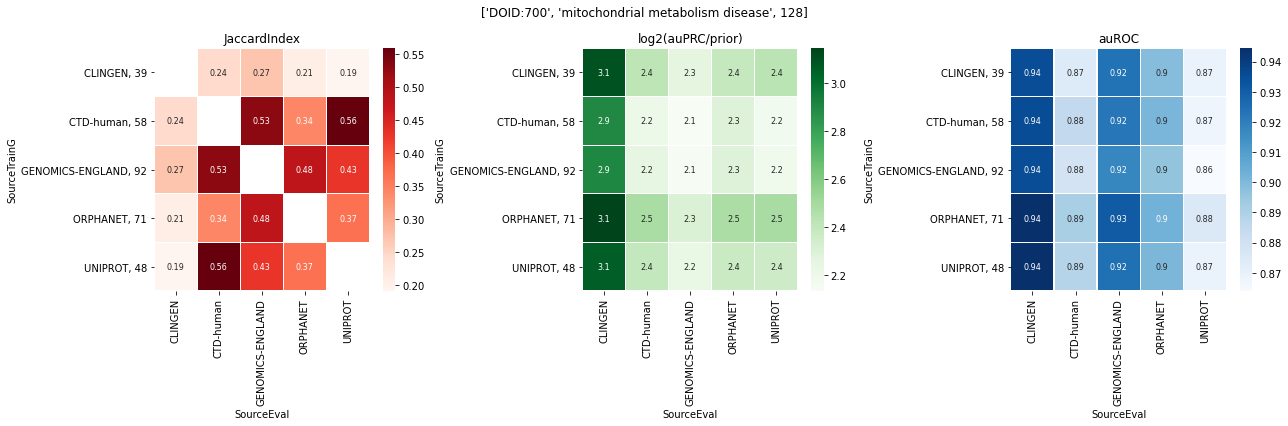

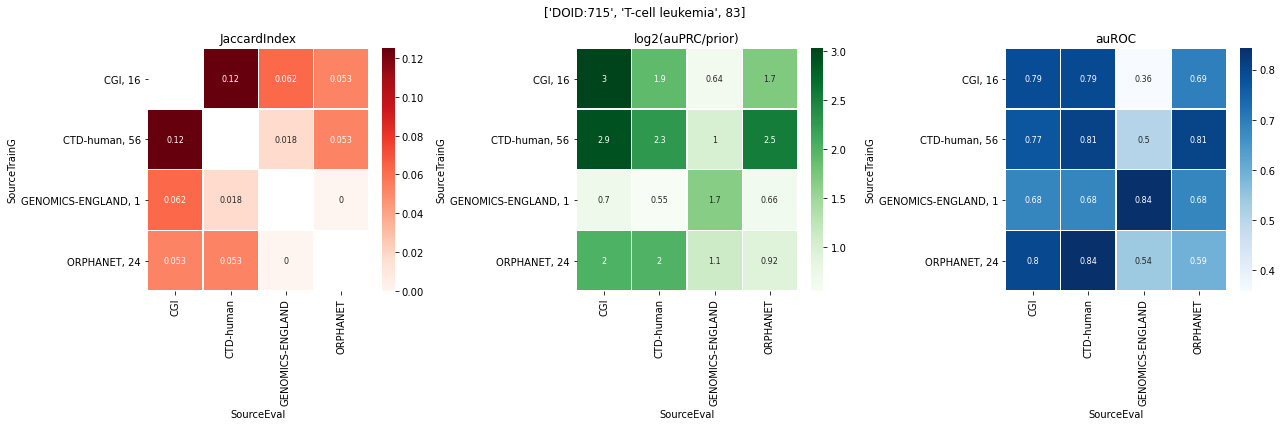

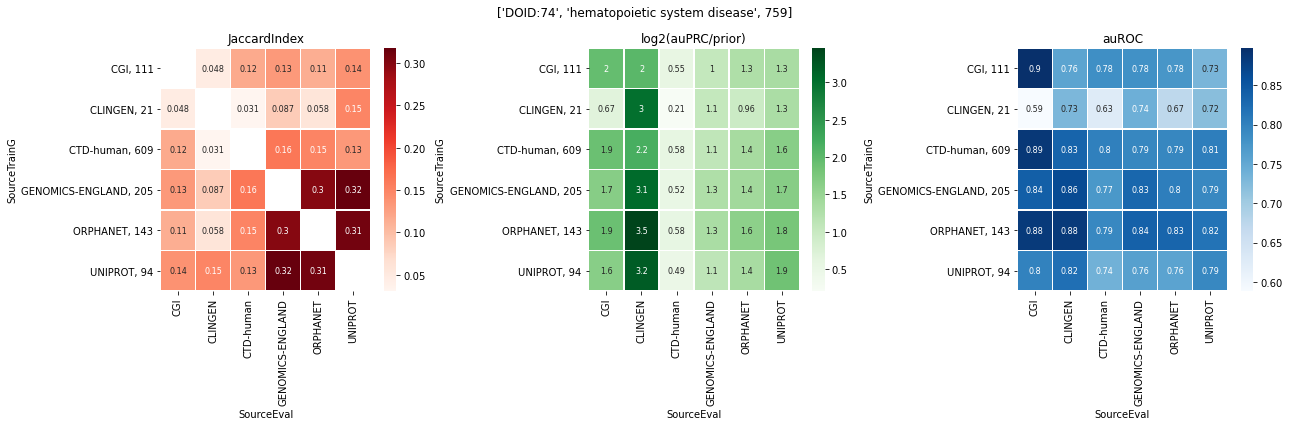

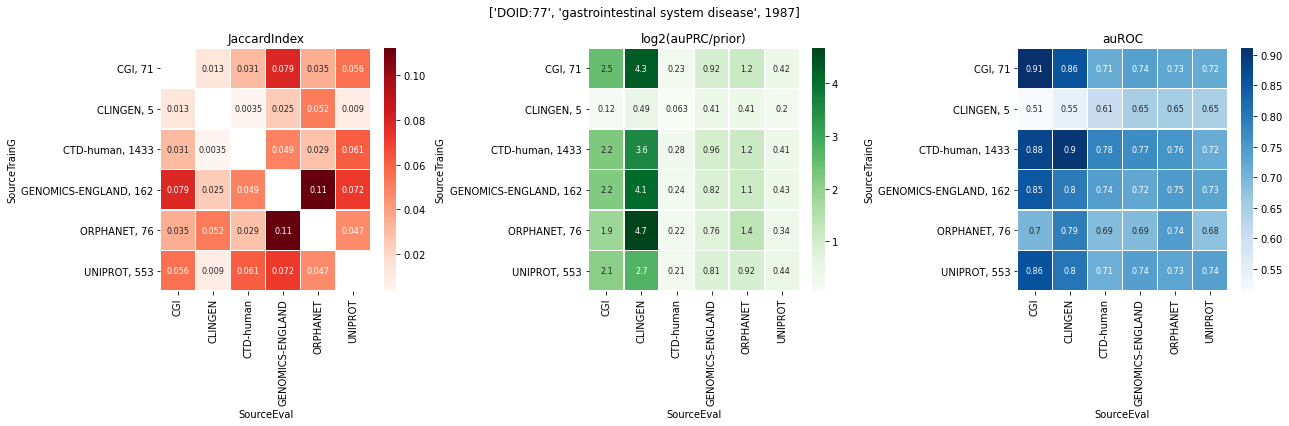

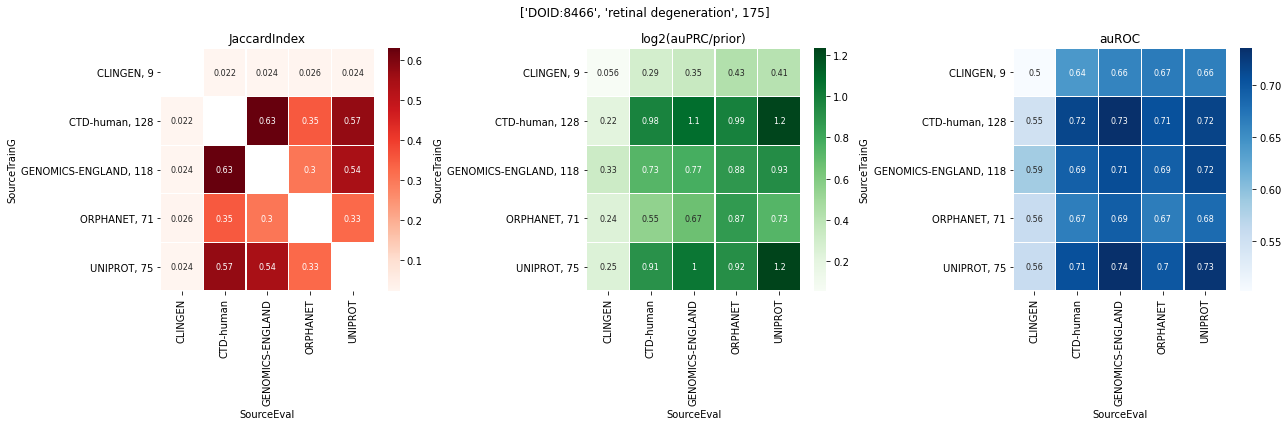

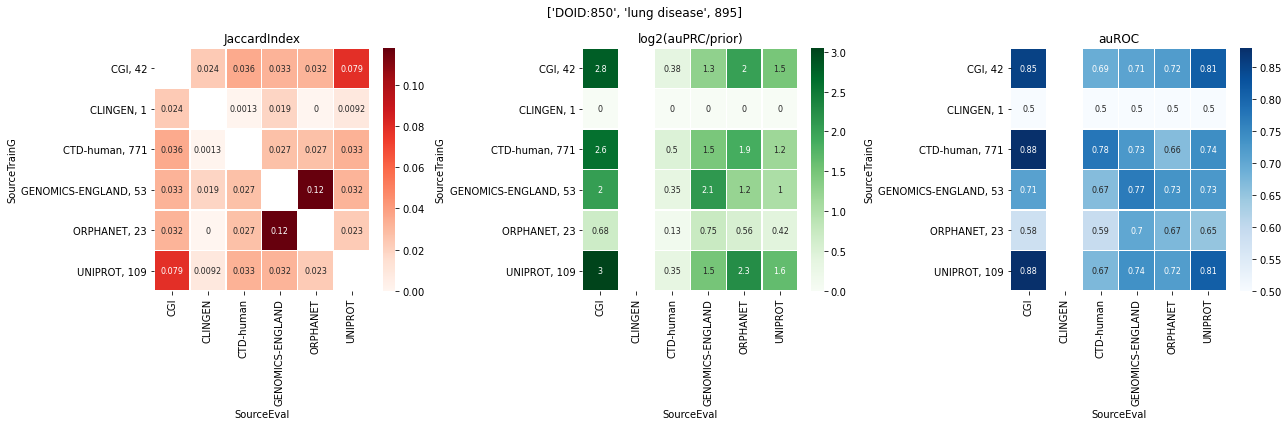

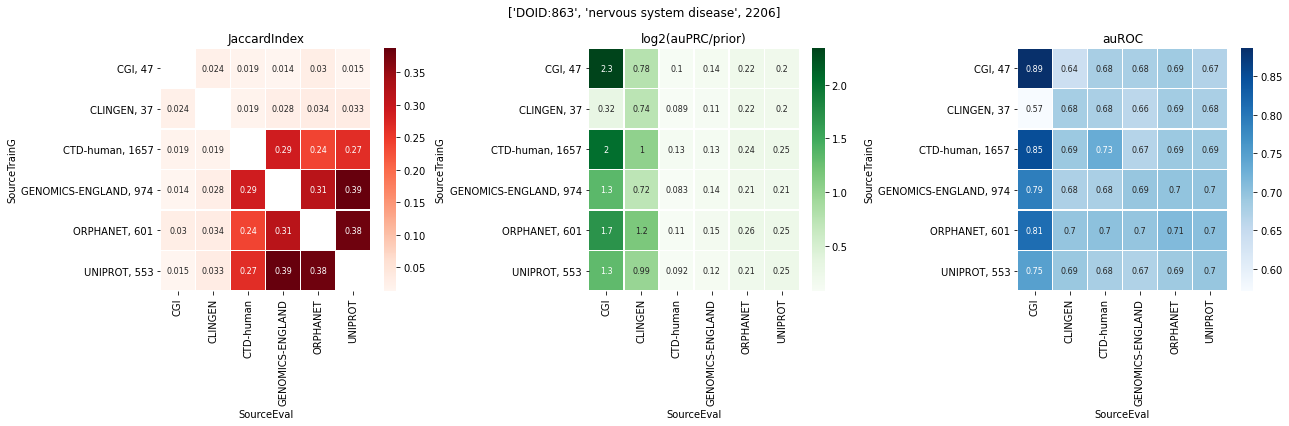

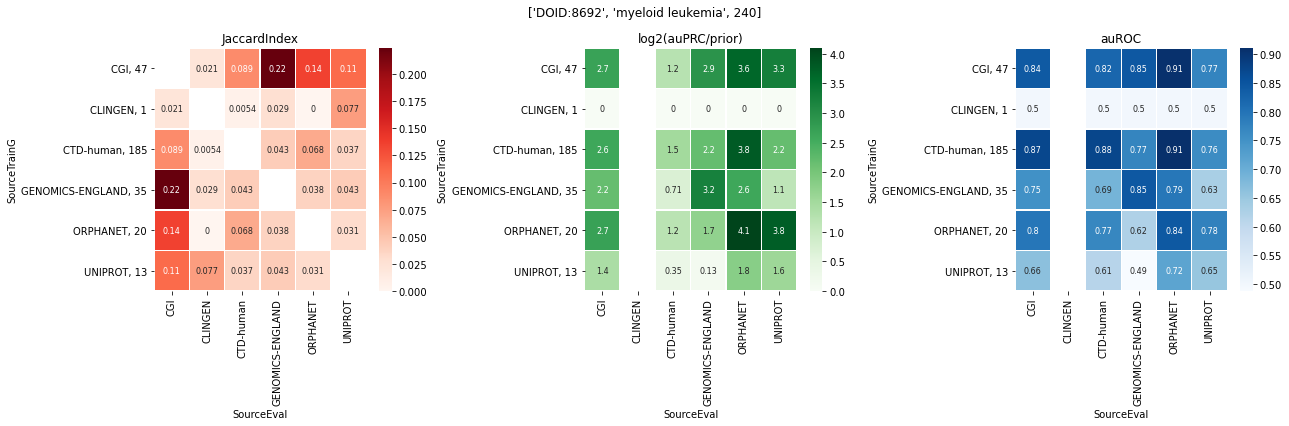

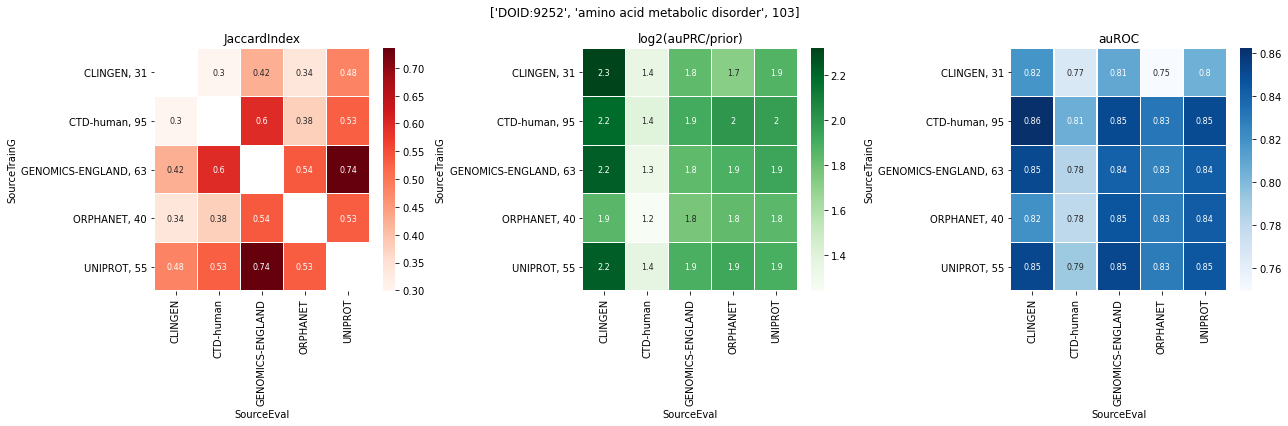

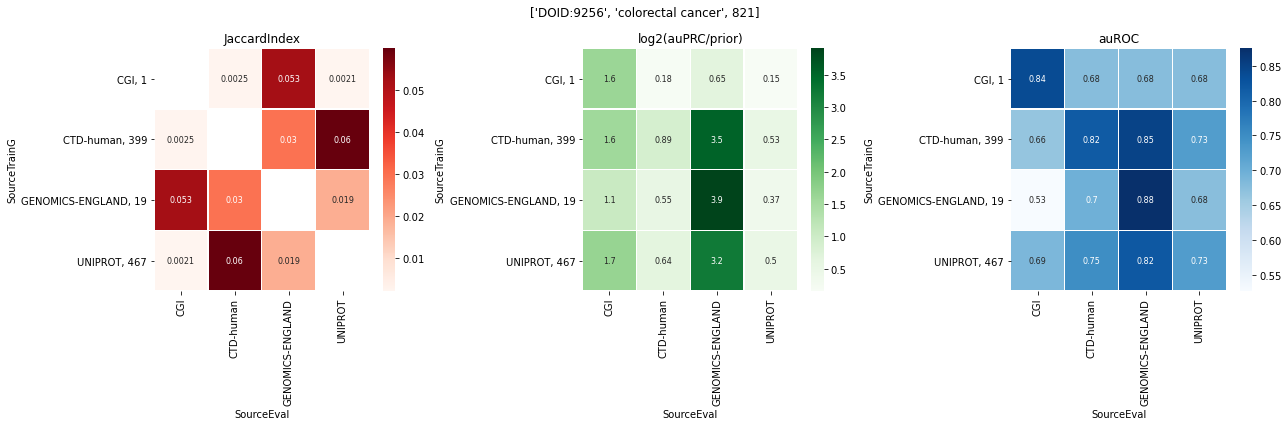

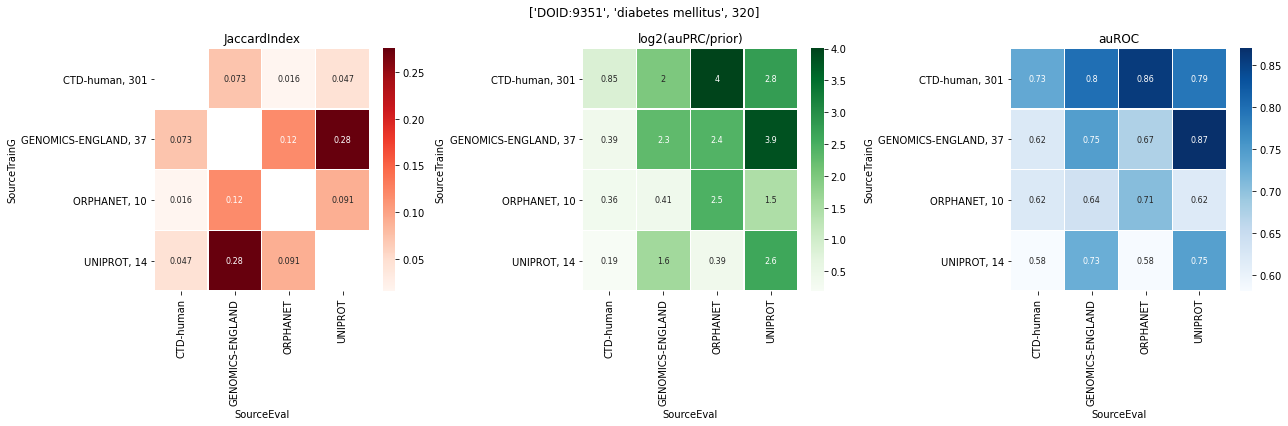

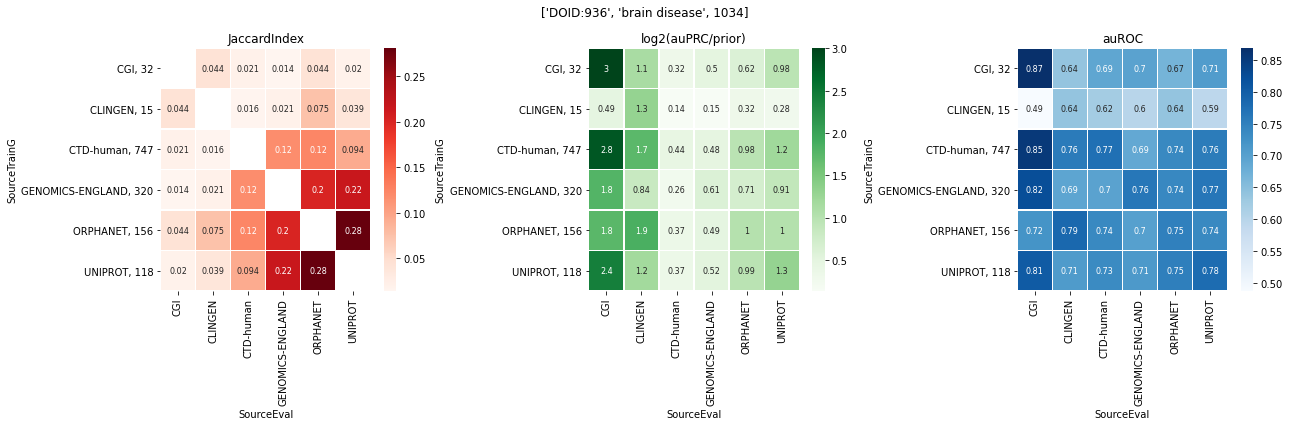

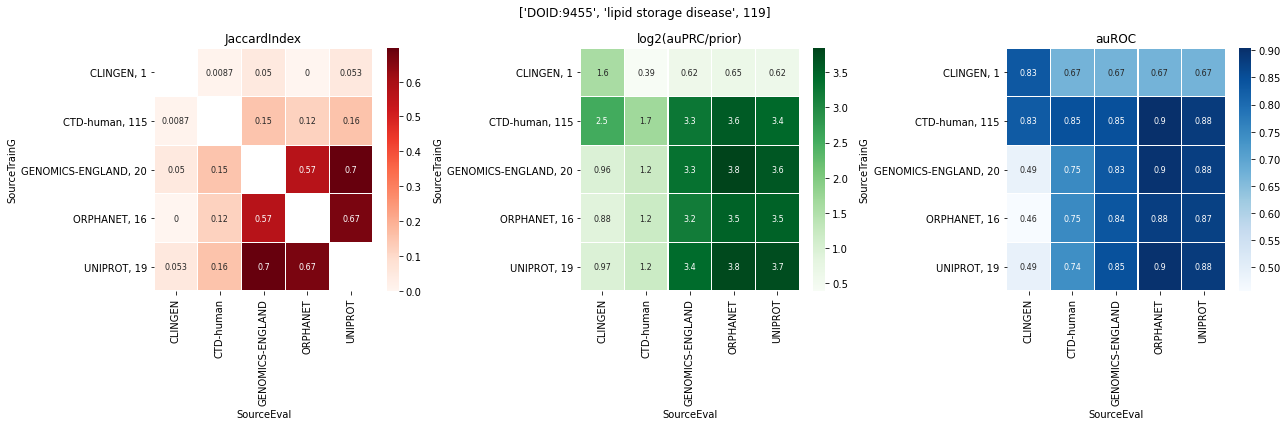

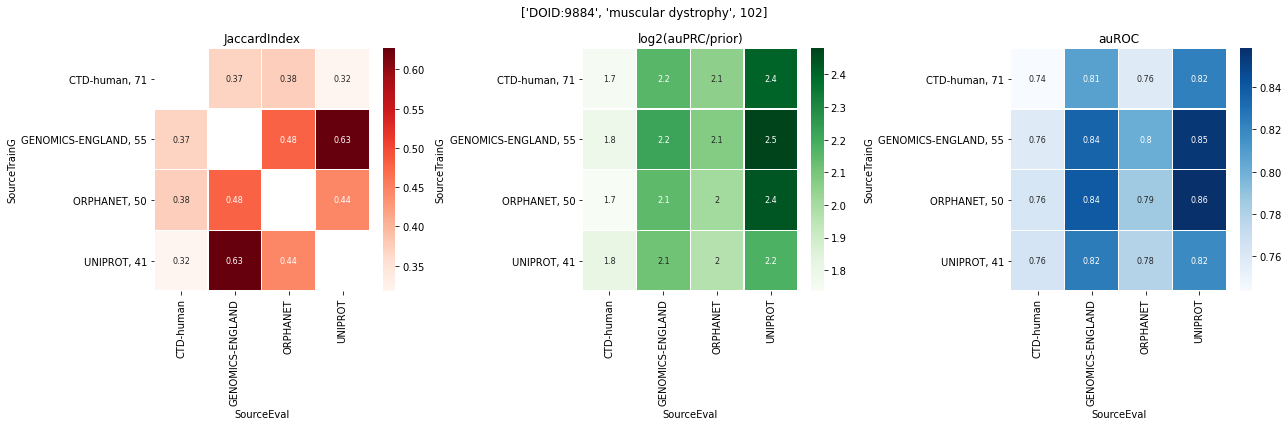

In [35]:
#CREATING THE HEATMAPS OF JACCARD, LOG2(AUPRC/PRIOR), AND AUROC SCORES FOR EACH DOID:
for DOID in dict_of_DOIDS:
    
    resultJaccard = dict_of_DOIDS[DOID].pivot("SourceTrainG", "SourceEval", "jaccardIndex")
    resultLog = dict_of_DOIDS[DOID].pivot("SourceTrainG", "SourceEval", "log2(auPRC/prior)")
    resultauROC = dict_of_DOIDS[DOID].pivot("SourceTrainG", "SourceEval", "auROC")
    plt.rcParams["figure.figsize"] = [18,6]
    
    f,(ax1,ax2,ax3) = plt.subplots(1,3)
    
    g1 = sns.heatmap(resultJaccard, annot = True, linewidths = .25, ax=ax1, cmap = 'Reds', annot_kws = {"size": 8})
    g1.set_title('JaccardIndex')
    
    g2 = sns.heatmap(resultLog, annot = True, linewidths = .25, ax=ax2, cmap = 'Greens', annot_kws = {"size": 8})
    g2.set_title('log2(auPRC/prior)')
    
    g3 = sns.heatmap(resultauROC, annot = True, linewidths = .25, ax=ax3, cmap = 'Blues', annot_kws = {"size": 8})
    g3.set_title('auROC')
    
    name = disease_ontology.nodes[DOID]["name"]
    genecount = dictGeneCounts[DOID]
    plt.suptitle(t = [DOID, name, genecount])
    
    plt.tight_layout()
    plt.show()

For every DOID the model trained/evaluated on, three heatmaps are created. The first heatmap is for the Jaccard Correlation Score, so this just maps each association type to every other association type available for that DOID, contrary to what the axes say. Those axes were more for the following two heatmaps, where the sources on the y-axis are the ones trained on by the model, while the ones on the x-axis are the ones evalbuated on. The number next to each source on each heatmap represents the count of genes from that source for that disease. The total unique count of genes can be found in the title. I have not been able to take the time to examine these heatmaps yet, but we hope we can determine for which association-type models types trained on were able to proficiently predict genes from another association type based on these plots.

Something I would like to note is that some of these heatmaps were not square; however, we expect them to be square since each association type for a DOID is being trained and evaluated on. Anna had found that the 10 diseases with non-square heatmaps had lost a column of data on their heatmap due to their files being 0 bytes and removed. These 0-byte files had no positive genes in our network, so we couldn’t effectively train a model and subsequently collect any performance metrics to analyze. Even with being removed, they would not have provided any useful information anyways.

## Creating Summary/Median Heatmaps

In [39]:
#First, grouping together Jaccard Indices:
df2 = finale.groupby(by = ['SourceTrain', 'SourceEval'])['jaccardIndex'].apply(lambda x: list(x))
df2 = df2.reset_index()

#Finding the median of the Jaccard Sets:
metricsets = df2['jaccardIndex']
medians = []
for alist in metricsets:
    medians.append(statistics.median(alist))
df2['medianJaccard'] = medians
df2

SourceTrain        SourceEval  \
0                CGI               CGI   
1                CGI           CLINGEN   
2                CGI         CTD-human   
3                CGI  GENOMICS-ENGLAND   
4                CGI          ORPHANET   
5                CGI          PSYGENET   
6                CGI           UNIPROT   
7            CLINGEN               CGI   
8            CLINGEN           CLINGEN   
9            CLINGEN         CTD-human   
10           CLINGEN  GENOMICS-ENGLAND   
11           CLINGEN          ORPHANET   
12           CLINGEN          PSYGENET   
13           CLINGEN           UNIPROT   
14         CTD-human               CGI   
15         CTD-human           CLINGEN   
16         CTD-human         CTD-human   
17         CTD-human  GENOMICS-ENGLAND   
18         CTD-human          ORPHANET   
19         CTD-human          PSYGENET   
20         CTD-human           UNIPROT   
21  GENOMICS-ENGLAND               CGI   
22  GENOMICS-ENGLAND           CLINGEN   
23  GENOMICS-ENGLAND         CTD-human   
24  GENOMICS-ENGLAND  GENOMICS-ENGLAND   
25  GENOMICS-ENGLAND          ORPHANET   
26  GENOMICS-ENGLAND          PSYGENET   
27  GENOMICS-ENGLAND           UNIPROT   
28          ORPHANET               CGI   
29          ORPHANET           CLINGEN   
30          ORPHANET         CTD-human   
31          ORPHANET  GENOMICS-ENGLAND   
32          ORPHANET          ORPHANET   
33          ORPHANET          PSYGENET   
34          ORPHANET           UNIPROT   
35          PSYGENET               CGI   
36          PSYGENET           CLINGEN   
37          PSYGENET         CTD-human   
38          PSYGENET  GENOMICS-ENGLAND   
39          PSYGENET          ORPHANET   
40          PSYGENET          PSYGENET   
41          PSYGENET           UNIPROT   
42           UNIPROT               CGI   
43           UNIPROT           CLINGEN   
44           UNIPROT         CTD-human   
45           UNIPROT  GENOMICS-ENGLAND   
46           UNIPROT          ORPHANET   
47           UNIPROT          PSYGENET   
48           UNIPROT           UNIPROT   

                                         jaccardIndex  medianJaccard  
0   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...            NaN  
1   [0.02127659574468085, 0.044444444444444446, 0....       0.023016  
2   [0.0892018779342723, 0.020969855832241154, 0.0...       0.050095  
3   [0.22388059701492538, 0.01440922190201729, 0.2...       0.087999  
4   [0.13559322033898305, 0.044444444444444446, 0....       0.058574  
5                                               [0.0]       0.000000  
6   [0.1111111111111111, 0.02040816326530612, 0.12...       0.066667  
7   [0.02127659574468085, 0.044444444444444446, 0....       0.023016  
8   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...            NaN  
9   [0.005405405405405406, 0.016, 0.01560874089490...       0.010753  
10  [0.02857142857142857, 0.021341463414634148, 0....       0.038902  
11  [0.0, 0.07547169811320754, 0.1188118811881188,...       0.030413  
12                       [0.0026086956521739132, 0.0]       0.001304  
13  [0.07692307692307693, 0.0390625, 0.1625, 0.038...       0.047619  
14  [0.0892018779342723, 0.020969855832241154, 0.0...       0.050095  
15  [0.005405405405405406, 0.016, 0.01560874089490...       0.010753  
16  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...            NaN  
17  [0.04265402843601896, 0.11844863731656184, 0.1...       0.084337  
18  [0.06770833333333333, 0.12453300124533001, 0.0...       0.099040  
19       [0.18176670441676104, 0.0021208907741251328]       0.091944  
20  [0.03664921465968586, 0.09355246523388117, 0.0...       0.070912  
21  [0.22388059701492538, 0.01440922190201729, 0.2...       0.087999  
22  [0.02857142857142857, 0.021341463414634148, 0....       0.038902  
23  [0.04265402843601896, 0.11844863731656184, 0.1...       0.084337  
24  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...            NaN  
25  [0.03773584905660377, 0.20202020202020202, 0.1...       0.

In [40]:
#Next, grouping together log2(auPRC/prior) values:
df3 = finale.groupby(by = ['SourceTrain', 'SourceEval'])['log2(auPRC/prior)'].apply(lambda x: list(x))
df3 = df3.reset_index()

#Finding the median of the log2(auPRC/prior) Sets:
metricsets = df3['log2(auPRC/prior)']
medians = []
for alist in metricsets:
    medians.append(statistics.median(alist))
df3['medianlog'] = medians
df3

SourceTrain        SourceEval  \
0                CGI               CGI   
1                CGI           CLINGEN   
2                CGI         CTD-human   
3                CGI  GENOMICS-ENGLAND   
4                CGI          ORPHANET   
5                CGI          PSYGENET   
6                CGI           UNIPROT   
7            CLINGEN               CGI   
8            CLINGEN           CLINGEN   
9            CLINGEN         CTD-human   
10           CLINGEN  GENOMICS-ENGLAND   
11           CLINGEN          ORPHANET   
12           CLINGEN          PSYGENET   
13           CLINGEN           UNIPROT   
14         CTD-human               CGI   
15         CTD-human           CLINGEN   
16         CTD-human         CTD-human   
17         CTD-human  GENOMICS-ENGLAND   
18         CTD-human          ORPHANET   
19         CTD-human          PSYGENET   
20         CTD-human           UNIPROT   
21  GENOMICS-ENGLAND               CGI   
22  GENOMICS-ENGLAND           CLINGEN   
23  GENOMICS-ENGLAND         CTD-human   
24  GENOMICS-ENGLAND  GENOMICS-ENGLAND   
25  GENOMICS-ENGLAND          ORPHANET   
26  GENOMICS-ENGLAND          PSYGENET   
27  GENOMICS-ENGLAND           UNIPROT   
28          ORPHANET               CGI   
29          ORPHANET           CLINGEN   
30          ORPHANET         CTD-human   
31          ORPHANET  GENOMICS-ENGLAND   
32          ORPHANET          ORPHANET   
33          ORPHANET          PSYGENET   
34          ORPHANET           UNIPROT   
35          PSYGENET               CGI   
36          PSYGENET           CLINGEN   
37          PSYGENET         CTD-human   
38          PSYGENET  GENOMICS-ENGLAND   
39          PSYGENET          ORPHANET   
40          PSYGENET          PSYGENET   
41          PSYGENET           UNIPROT   
42           UNIPROT               CGI   
43           UNIPROT           CLINGEN   
44           UNIPROT         CTD-human   
45           UNIPROT  GENOMICS-ENGLAND   
46           UNIPROT          ORPHANET   
47           UNIPROT          PSYGENET   
48           UNIPROT           UNIPROT   

                                    log2(auPRC/prior)  medianlog  
0   [2.698849837862657, 3.000408159694417, 2.51223...   2.805199  
1   [nan, 1.1439661979693712, 5.19377174339668, 4....   2.099755  
2   [1.2351175352853816, 0.322752944686915, 0.6737...   0.549997  
3   [2.938505328033676, 0.5021089908237251, 0.6831...   1.125841  
4   [3.6483314150813184, 0.6159831255034284, 1.332...   1.806968  
5                                               [0.0]   0.000000  
6   [3.2694232488656776, 0.9774032331983116, 1.799...   1.496476  
7   [0.0, 0.4861779069716332, 0.552601509526756, -...   0.475823  
8   [1.3089253805853611, 1.4675598869849087, 1.530...   1.548503  
9   [0.0, 0.1391658145280197, 0.1762350656313407, ...   0.197292  
10  [0.0, 0.1496703755702084, 0.5430317320344542, ...   0.542779  
11  [0.0, 0.3232909821783186, 1.2494214549095946, ...   0.520441  
12           [0.1170079475421206, 1.1244113359619132]   0.620710  
13  [0.0, 0.278983245821403, 1.1253186620972395, 0...   0.538098  
14  [2.614241157262988, 2.8265838206782665, 2.2576...   2.609873  
15  [nan, 1.7380003227642604, 1.4920535168058564, ...   2.808603  
16  [1.516264176046009, 0.441566349997494, 0.34716...   0.976807  
17  [2.1925356189566303, 0.480380222901778, 0.5385...   1.955178  
18  [3.8014784607715297, 0.9837439492644556, 1.220...   2.009745  
19           [0.3038987948065142, 2.5529591833867364]   1.428429  
20  [2.1873589239678504, 1.2154078137925906, 1.353...   1.934228  
21  [2.188158604333218, 1.8032245836014924, 0.0684...   1.551529  
22  [nan, 0.843532588013441, 2.125963780193114, 0....   1.086082  
23  [0.7102053228998796, 0.2566684881373158, 0.227...   0.547907  
24  [3.228808929103782, 0.6125510248108988, 0.6528...   1.601627  
25  [2.618630120806433, 0.7090139195096621, 1.4187...   1.327282  
26            [0.175600940736099, 1.8737553087841785]   1.024678  
27  [1.1408293621310115, 0.90784

In [41]:
#Finally, grouping together auROC values:
df4 = finale.groupby(by = ['SourceTrain', 'SourceEval'])['auROC'].apply(lambda x: list(x))
df4 = df4.reset_index()

#Finding the median of the auROC sets:
metricsets = df4['auROC']
medians = []
for alist in metricsets:
    medians.append(statistics.median(alist))
df4['medianauROC'] = medians
df4

SourceTrain        SourceEval  \
0                CGI               CGI   
1                CGI           CLINGEN   
2                CGI         CTD-human   
3                CGI  GENOMICS-ENGLAND   
4                CGI          ORPHANET   
5                CGI          PSYGENET   
6                CGI           UNIPROT   
7            CLINGEN               CGI   
8            CLINGEN           CLINGEN   
9            CLINGEN         CTD-human   
10           CLINGEN  GENOMICS-ENGLAND   
11           CLINGEN          ORPHANET   
12           CLINGEN          PSYGENET   
13           CLINGEN           UNIPROT   
14         CTD-human               CGI   
15         CTD-human           CLINGEN   
16         CTD-human         CTD-human   
17         CTD-human  GENOMICS-ENGLAND   
18         CTD-human          ORPHANET   
19         CTD-human          PSYGENET   
20         CTD-human           UNIPROT   
21  GENOMICS-ENGLAND               CGI   
22  GENOMICS-ENGLAND           CLINGEN   
23  GENOMICS-ENGLAND         CTD-human   
24  GENOMICS-ENGLAND  GENOMICS-ENGLAND   
25  GENOMICS-ENGLAND          ORPHANET   
26  GENOMICS-ENGLAND          PSYGENET   
27  GENOMICS-ENGLAND           UNIPROT   
28          ORPHANET               CGI   
29          ORPHANET           CLINGEN   
30          ORPHANET         CTD-human   
31          ORPHANET  GENOMICS-ENGLAND   
32          ORPHANET          ORPHANET   
33          ORPHANET          PSYGENET   
34          ORPHANET           UNIPROT   
35          PSYGENET               CGI   
36          PSYGENET           CLINGEN   
37          PSYGENET         CTD-human   
38          PSYGENET  GENOMICS-ENGLAND   
39          PSYGENET          ORPHANET   
40          PSYGENET          PSYGENET   
41          PSYGENET           UNIPROT   
42           UNIPROT               CGI   
43           UNIPROT           CLINGEN   
44           UNIPROT         CTD-human   
45           UNIPROT  GENOMICS-ENGLAND   
46           UNIPROT          ORPHANET   
47           UNIPROT          PSYGENET   
48           UNIPROT           UNIPROT   

                                                auROC  medianauROC  
0   [0.8422891753377854, 0.8683894230769231, 0.699...     0.853978  
1   [nan, 0.6393162393162393, 0.9744525547445256, ...     0.715022  
2   [0.8218160424394719, 0.6925600871909596, 0.673...     0.700947  
3   [0.8461418143899896, 0.6978214564965353, 0.571...     0.717489  
4   [0.9074817518248176, 0.6675382366171839, 0.698...     0.757529  
5                                               [0.5]     0.500000  
6   [0.7748455923638407, 0.7088946834709547, 0.757...     0.744846  
7   [0.5, 0.4869791666666666, 0.6551094890510949, ...     0.578336  
8   [0.6403133903133903, 0.6918940060623837, 0.827...     0.823529  
9   [0.5, 0.6234641197728445, 0.6526115050000216, ...     0.652612  
10  [0.5, 0.5998139610126992, 0.7378793064111339, ...     0.659341  
11  [0.5, 0.6394230769230771, 0.7447102937237746, ...     0.667046  
12            [0.6260600936286406, 0.482311320754717]     0.554186  
13  [0.5, 0.5928943937418514, 0.6878279717088752, ...     0.664244  
14  [0.8732334213387172, 0.8548344017094017, 0.846...     0.862191  
15  [nan, 0.7585470085470085, 0.6851471594798083, ...     0.853235  
16  [0.8759223804395516, 0.7742499856593815, 0.762...     0.797173  
17  [0.7720542231491136, 0.6870365876675024, 0.722...     0.802260  
18  [0.9105839416058392, 0.7376433873144399, 0.772...     0.691836  
19           [0.7621254213837859, 0.5176886792452831]     0.639907  
20  [0.7612296462661426, 0.7580399826162538, 0.751...     0.780694  
21  [0.7526401615157633, 0.8240518162393162, 0.531...     0.713778  
22  [nan, 0.6925925925925926, 0.8023858414002151, ...     0.769450  
23  [0.6879063459774242, 0.6970659094820169, 0.695...     0.697066  
24  [0.845672575599583, 0.763791151015126, 0.79744...     0.788417  
25  [0.7948905109489051, 0.7396957939721098, 0.795...     0.550166  
26           [0.6779255289944986, 0.491745283

In [53]:
#First, merging log2(auPRC/prior) and auROC datasets
#Note, we needed to keep the Median Jaccard dataset separate because that heatmap would need to be created separately, since we have to hide the diagonal for only this one.
merge1 = df4.merge(df3)
merge1

SourceTrain        SourceEval  \
0                CGI               CGI   
1                CGI           CLINGEN   
2                CGI         CTD-human   
3                CGI  GENOMICS-ENGLAND   
4                CGI          ORPHANET   
5                CGI          PSYGENET   
6                CGI           UNIPROT   
7            CLINGEN               CGI   
8            CLINGEN           CLINGEN   
9            CLINGEN         CTD-human   
10           CLINGEN  GENOMICS-ENGLAND   
11           CLINGEN          ORPHANET   
12           CLINGEN          PSYGENET   
13           CLINGEN           UNIPROT   
14         CTD-human               CGI   
15         CTD-human           CLINGEN   
16         CTD-human         CTD-human   
17         CTD-human  GENOMICS-ENGLAND   
18         CTD-human          ORPHANET   
19         CTD-human          PSYGENET   
20         CTD-human           UNIPROT   
21  GENOMICS-ENGLAND               CGI   
22  GENOMICS-ENGLAND           CLINGEN   
23  GENOMICS-ENGLAND         CTD-human   
24  GENOMICS-ENGLAND  GENOMICS-ENGLAND   
25  GENOMICS-ENGLAND          ORPHANET   
26  GENOMICS-ENGLAND          PSYGENET   
27  GENOMICS-ENGLAND           UNIPROT   
28          ORPHANET               CGI   
29          ORPHANET           CLINGEN   
30          ORPHANET         CTD-human   
31          ORPHANET  GENOMICS-ENGLAND   
32          ORPHANET          ORPHANET   
33          ORPHANET          PSYGENET   
34          ORPHANET           UNIPROT   
35          PSYGENET               CGI   
36          PSYGENET           CLINGEN   
37          PSYGENET         CTD-human   
38          PSYGENET  GENOMICS-ENGLAND   
39          PSYGENET          ORPHANET   
40          PSYGENET          PSYGENET   
41          PSYGENET           UNIPROT   
42           UNIPROT               CGI   
43           UNIPROT           CLINGEN   
44           UNIPROT         CTD-human   
45           UNIPROT  GENOMICS-ENGLAND   
46           UNIPROT          ORPHANET   
47           UNIPROT          PSYGENET   
48           UNIPROT           UNIPROT   

                                                auROC  medianauROC  \
0   [0.8422891753377854, 0.8683894230769231, 0.699...     0.853978   
1   [nan, 0.6393162393162393, 0.9744525547445256, ...     0.715022   
2   [0.8218160424394719, 0.6925600871909596, 0.673...     0.700947   
3   [0.8461418143899896, 0.6978214564965353, 0.571...     0.717489   
4   [0.9074817518248176, 0.6675382366171839, 0.698...     0.757529   
5                                               [0.5]     0.500000   
6   [0.7748455923638407, 0.7088946834709547, 0.757...     0.744846   
7   [0.5, 0.4869791666666666, 0.6551094890510949, ...     0.578336   
8   [0.6403133903133903, 0.6918940060623837, 0.827...     0.823529   
9   [0.5, 0.6234641197728445, 0.6526115050000216, ...     0.652612   
10  [0.5, 0.5998139610126992, 0.7378793064111339, ...     0.659341   
11  [0.5, 0.6394230769230771, 0.7447102937237746, ...     0.667046   
12            [0.6260600936286406, 0.482311320754717]     0.554186   
13  [0.5, 0.5928943937418514, 0.6878279717088752, ...     0.664244   
14  [0.8732334213387172, 0.8548344017094017, 0.846...     0.862191   
15  [nan, 0.7585470085470085, 0.6851471594798083, ...     0.853235   
16  [0.8759223804395516, 0.7742499856593815, 0.762...     0.797173   
17  [0.7720542231491136, 0.6870365876675024, 0.722...     0.802260   
18  [0.9105839416058392, 0.7376433873144399, 0.772...     0.691836   
19           [0.7621254213837859, 0.5176886792452831]     0.639907   
20  [0.7612296462661426, 0.7580399826162538, 0.751...     0.780694   
21  [0.7526401615157633, 0.8240518162393162, 0.531...     0.713778   
22  [nan, 0.6925925925925926, 0.8023858414002151, ...     0.769450   
23  [0.6879063459774242, 0.6970659094820169, 0.695...     0.697066   
24  [0.845672575599583, 0.763791151015126, 0.79744...     0.788417   
25  [0.7948905109489051, 0.7396957939721098, 0.795...     0.550166   
26           [0.67

In [54]:
#Finding the median number of genes in each source to be added as part of the label for the heatmaps
selected.median(axis=0, skipna=True, numeric_only=True)

numgenes_CLINGEN               2.0
numgenes_CGI                  13.0
numgenes_CTD_human           241.0
numgenes_GENOMICS_ENGLAND     51.0
numgenes_ORPHANET             31.0
numgenes_PSYGENET              0.0
numgenes_UNIPROT              41.0
numgenes_dir                  32.0
numgenes_prop                297.0
numsource_ge10                 4.0
dtype: float64

In [55]:
#Creating the labels for the heatmaps (Source, Median number of genes for the source, Total number of unique genes for the source[found from the website itself]):
Trainlist = []

for index, row in merge1.iterrows():
    if (row['SourceTrain'] == 'CLINGEN'):
        temp = row['SourceTrain'] + ', 2, 634' 
        Trainlist.append(temp)
    elif (row['SourceTrain'] == 'CGI'):
        temp = row['SourceTrain'] + ', 13, 315'
        Trainlist.append(temp)
    elif (row['SourceTrain'] == 'CTD-human'):
        temp = row['SourceTrain'] + ', 241, 8247'
        Trainlist.append(temp)                                           
    elif (row['SourceTrain'] == 'GENOMICS-ENGLAND'):
        temp = row['SourceTrain'] + ', 51, 3967'
        Trainlist.append(temp)
    elif (row['SourceTrain'] == 'ORPHANET'):
        temp = row['SourceTrain'] + ', 31, 3356'
        Trainlist.append(temp)
    elif (row['SourceTrain'] == 'PSYGENET'):
        temp = row['SourceTrain'] + ', 0, 1393'
        Trainlist.append(temp)
    elif (row['SourceTrain'] == 'UNIPROT'):
        temp = row['SourceTrain'] + ', 41, 3894'
        Trainlist.append(temp)

In [56]:
#Similarly creating the labels for the Median Jaccard Dataset (df2):
Trainlistdf2 = []

for index, row in df2.iterrows():
    if (row['SourceTrain'] == 'CLINGEN'):
        temp = row['SourceTrain'] + ', 2, 634' 
        Trainlistdf2.append(temp)
    elif (row['SourceTrain'] == 'CGI'):
        temp = row['SourceTrain'] + ', 13, 315'
        Trainlistdf2.append(temp)
    elif (row['SourceTrain'] == 'CTD-human'):
        temp = row['SourceTrain'] + ', 241, 8247'
        Trainlistdf2.append(temp)                                           
    elif (row['SourceTrain'] == 'GENOMICS-ENGLAND'):
        temp = row['SourceTrain'] + ', 51, 3967'
        Trainlistdf2.append(temp)
    elif (row['SourceTrain'] == 'ORPHANET'):
        temp = row['SourceTrain'] + ', 31, 3356'
        Trainlistdf2.append(temp)
    elif (row['SourceTrain'] == 'PSYGENET'):
        temp = row['SourceTrain'] + ', 0, 1393'
        Trainlistdf2.append(temp)
    elif (row['SourceTrain'] == 'UNIPROT'):
        temp = row['SourceTrain'] + ', 41, 3894'
        Trainlistdf2.append(temp)

In [57]:
#Adding the labels as another column to our two datasets:
df2['SourceTrainG'] = Trainlistdf2
merge1['SourceTrainG'] = Trainlist

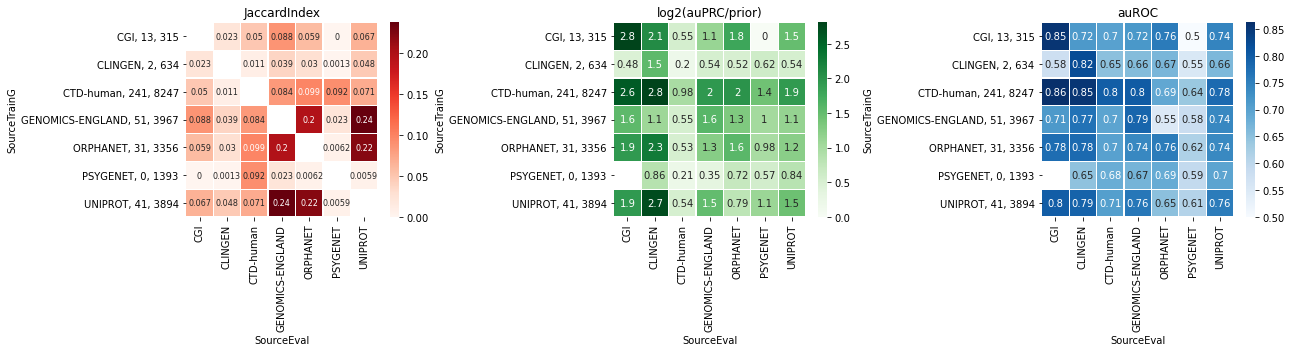

In [60]:
#Heatmap of median jaccard, log2(auprc/prior), and auroc scores for source pairs
resultJaccard2 = df2.pivot("SourceTrainG", "SourceEval", "medianJaccard")
resultLog2 = merge1.pivot("SourceTrainG", "SourceEval", "medianlog")
resultauROC2 = merge1.pivot("SourceTrainG", "SourceEval", "medianauROC")
plt.rcParams["figure.figsize"] = [18,5]

f,(ax1,ax2,ax3) = plt.subplots(1,3) 
g1 = sns.heatmap(resultJaccard2, annot = True, linewidths = .25, cmap = 'Reds', ax = ax1, annot_kws={"size": 8})

g1.set_title('JaccardIndex')
g2 = sns.heatmap(resultLog2, annot = True, linewidths = .25, cmap = 'Greens', ax = ax2)

g2.set_title('log2(auPRC/prior)')
g3 = sns.heatmap(resultauROC2, annot = True, linewidths = .25, cmap = 'Blues', ax = ax3)

g3.set_title('auROC')

plt.tight_layout()
plt.show()

I finally created summary heatmaps of the median jaccard correlation, log2(auPRC/prior), and auROC scores for source pairs. Similar to earlier, I grouped together all the values for each of these three scores into sets by source pairs and found their median value, which is plotted in their respective square. Therefore, the first plot of the jaccard score is the exact same type of heatmap I’ve been creating for the previous parts of this project, and the following two follow the same idea, just using a different score. Specifically, the second is showing the median log2(auPRC/prior), which tells us how much better our model did than random performance, and the third is showing the median auROC, which tells us the probability that, if we select one positive and one negative from our data, our model will rank the positive higher than the negative. I again have not gotten the chance to examine these heatmaps in detail yet, but one thing to note is the one blank spot in the second and third heatmap. For both heamtaps, the square for when PSYGENET is trained on and CGI is evaluated on is blank because the model did not have the necessary data to do this comparison. This is not surprising when we remember that PSYGENET and CGI have the two smallest number of disease-gene pairs available. Overall, this is helping us to see some sources trained on generally do better to predict genes from another source.

## Conclusion:

We sought out to answer:
1. Do different experimental methods provide the same view of the underlying biology, or do they present different aspects of it?
2. Can models trained on one experimental method predict the genes associated to another?

Overall, we determined some sources and association types demonstrate little correlation to others, represented by their low jaccard index values. However, a few provide similar views of the underlying biology. Furthermore, based on the high-performance metrics for certain sources trained or evaluated on, models trained on one experimental method can predict genes associated to another.

## Future Work:

After reviewing the metrics of the selected diseases further, we plan to combine the machine learning models from the distinct sources into an ensemble model that discovers novel genes across the human genome associated with the disease. I will also make my work readily available to members of the Krishnan laboratory to allow the results to be incorporated into further disease study. 


## References:
https://www.disgenet.org/home/

## Acknowledgements:
This project would not have been possible without the unwavering support from my graduate student mentor, Anna, from my main mentor, Dr. Arjun Krishnan, and from all of the REU Staff (especially Laura Harris, Brian O’Shea)!

This project has been a great and unforgettable experience for me, and I hope my work can be used in further disease-gene study!